In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
counties = gpd.read_file(r"C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\tl_2021_us_county.shp").to_crs(4326)

In [3]:
counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [4]:
tri_states = counties[counties["STATEFP"].isin(["21","39","54"])]

In [5]:
zones_2012 = gpd.read_file(r"C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\phm_us_shp.shp")
zones_2023 = gpd.read_file(r"C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\phzm_us_zones_shp_2023.shp")

In [6]:
zones_2012 = zones_2012.to_crs(4326)
zones_2023 = zones_2023.to_crs(4326)

In [7]:
zones_2023.rename(columns={'zonetitle': 'ZONE'}, inplace=True)

In [8]:
zones23_clip = gpd.clip(zones_2023, tri_states.union_all()).reset_index()

In [9]:
zones12_clip = gpd.clip(zones_2012, tri_states.union_all()).reset_index()

In [10]:
merged_2012 = pd.concat([tri_states, zones12_clip], ignore_index=True)

In [11]:
zones12_clip.drop('index', axis=1, inplace=True)
zones12_clip

,ID,GRIDCODE,ZONE,geometry
0,93953,13,7a: 0 to 5 F,"MULTIPOLYGON (((-88.4875 37.24583, -88.4875 37..."
1,76928,13,7a: 0 to 5 F,"POLYGON ((-83.52083 36.74583, -83.52083 36.762..."
2,76870,13,7a: 0 to 5 F,"POLYGON ((-83.52917 36.7625, -83.52917 36.7541..."
3,76826,13,7a: 0 to 5 F,"POLYGON ((-83.3375 36.77083, -83.32917 36.7708..."
4,76825,12,6b: -5 to 0 F,"POLYGON ((-83.34583 36.7625, -83.34583 36.7708..."
...,...,...,...,...
2601,45675,12,6b: -5 to 0 F,"POLYGON ((-82.10416 41.45416, -82.1375 41.4541..."
2602,45717,11,6a: -10 to -5 F,"POLYGON ((-82.47083 41.44583, -82.47083 41.454..."
2603,45628,12,6b: -5 to 0 F,"POLYGON ((-82.10416 41.47083, -82.0875 41.4708..."
2604,45471,11,6a: -10 to -5 F,"POLYGON ((-82.42083 41.49583, -82.4125 41.4958..."


In [12]:
zones23_clip.drop('index', axis=1, inplace=True)
zones23_clip

,Id,gridcode,zone,trange,ZONE,geometry
0,10,9,7b,5 to 10,7b: 5 to 10,"MULTIPOLYGON (((-89.15417 36.84583, -89.15417 ..."
1,9,8,7a,0 to 5,7a: 0 to 5,"MULTIPOLYGON (((-86.35417 38.17083, -86.3375 3..."
2,8,7,6b,-5 to 0,6b: -5 to 0,"MULTIPOLYGON (((-84.79583 39.42083, -84.79583 ..."
3,7,6,6a,-10 to -5,6a: -10 to -5,"MULTIPOLYGON (((-83.75416 41.70416, -83.77083 ..."
4,6,5,5b,-15 to -10,5b: -15 to -10,"MULTIPOLYGON (((-80.24583 38.27083, -80.24583 ..."


In [13]:
zones12_clip.geom_type.value_counts()
zones23_clip.geom_type.value_counts()

zones12_clip.explode(index_parts=False).shape
zones23_clip.explode(index_parts=False).shape

(2987, 6)

In [14]:
merged_2012.to_csv('merged2012.csv', index=False)

In [15]:
merged_2023 = pd.concat([tri_states, zones23_clip], ignore_index=True)

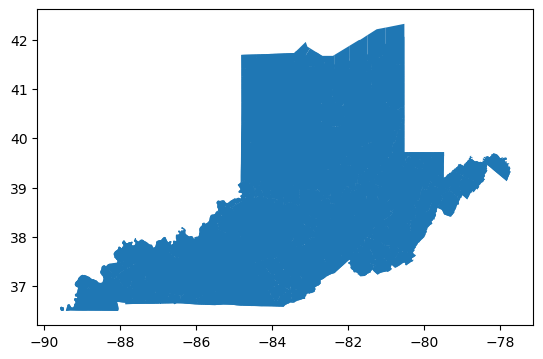

In [16]:
merged_2012.plot();

In [17]:
def clean_and_dissolve(gdf, zone_col='ZONE', min_area_km2=1.0, proj_crs='EPSG:5070', out_crs='EPSG:4326'):
   
    g = gdf.copy()

    g = g.to_crs(proj_crs)

    g['geometry'] = g.buffer(0)
    min_area_m2 = float(min_area_km2) * 1_000_000.0
    g = g[g.area >= min_area_m2]

    out = g[[zone_col, 'geometry']].dissolve(by=zone_col, as_index=False)
    out = out.explode(index_parts=False, ignore_index=True)

    return out.to_crs(out_crs)


In [18]:
zones12_std = clean_and_dissolve(zones12_clip, zone_col='ZONE', min_area_km2=1.0)
zones23_std = clean_and_dissolve(zones23_clip, zone_col='ZONE', min_area_km2=1.0)

print(len(zones12_std), len(zones23_std))

1129 2987


In [19]:
z12 = zones12_std.to_crs(tri_states.crs)
z23 = zones23_std.to_crs(tri_states.crs)
counties = tri_states.copy()

def dominant_zone_by_county(zones, counties, zone_col='ZONE'):
    inter = gpd.overlay(counties[['GEOID','NAME','geometry']],
                        zones[[zone_col,'geometry']], how='intersection')
    inter['part_area'] = inter.geometry.to_crs('EPSG:5070').area  
    totals = inter.groupby('GEOID', as_index=False)['part_area'].sum().rename(columns={'part_area':'tot'})
    inter = inter.merge(totals, on='GEOID', how='left')
    inter['share'] = inter['part_area'] / inter['tot']
    dom = (inter.sort_values(['GEOID','share'], ascending=[True, False])
                 .drop_duplicates('GEOID')[['GEOID', zone_col]])
    return counties.merge(dom, on='GEOID', how='left')

counties12 = dominant_zone_by_county(z12, counties, zone_col='ZONE')
counties23 = dominant_zone_by_county(z23, counties, zone_col='ZONE')

print(len(counties12), len(counties23))  

263 263


In [20]:
counties12['ZONE'] = counties12['ZONE'].str.replace('F', '', regex=False).str.strip()

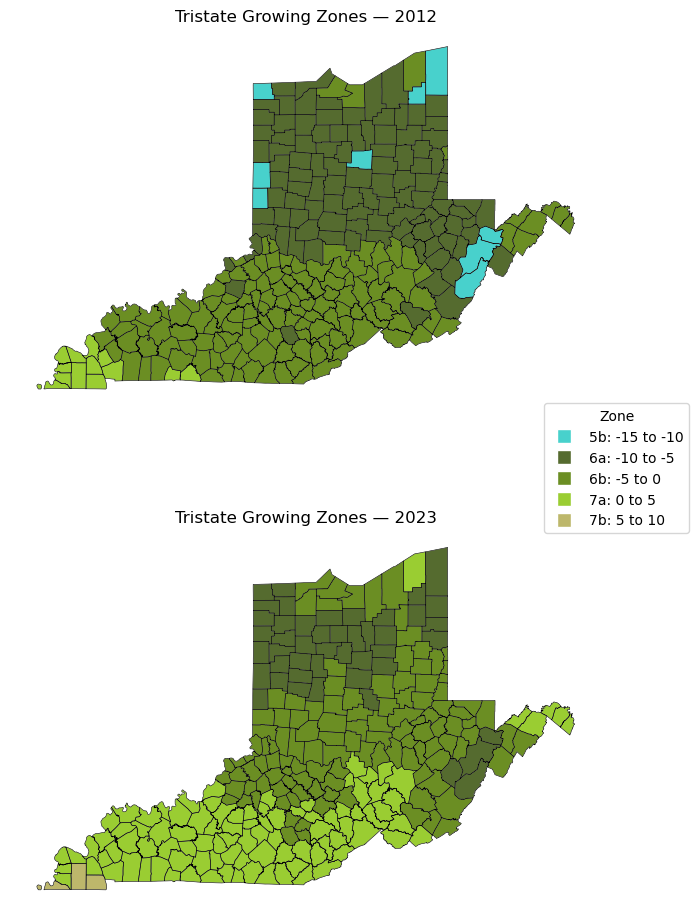

In [21]:
import matplotlib.colors as mcolors

zone_colors = {
    '5b: -15 to -10': 'mediumturquoise',  
    '6a: -10 to -5': 'darkolivegreen',
    '6b: -5 to 0': 'olivedrab', 
    '7a: 0 to 5': 'yellowgreen',
    '7b: 5 to 10': 'darkkhaki'
}

counties12['color'] = counties12['ZONE'].map(zone_colors)
counties23['color'] = counties23['ZONE'].map(zone_colors)

fig, axes = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

counties12.plot(color=counties12['color'], ax=axes[0], edgecolor='white', linewidth=0.3)
counties.boundary.plot(ax=axes[0], color='black', linewidth=0.4) 
axes[0].set_title('Tristate Growing Zones — 2012')
axes[0].set_axis_off()

counties23.plot(color=counties23['color'], ax=axes[1], edgecolor='white', linewidth=0.3)
counties.boundary.plot(ax=axes[1], color='black', linewidth=0.4)
axes[1].set_title('Tristate Growing Zones — 2023')
axes[1].set_axis_off()

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=zone,
           markerfacecolor=color, markersize=10)
    for zone, color in zone_colors.items()
]

fig.legend(handles=legend_elements, title="Zone", loc='center right', bbox_to_anchor=(1.15, 0.5))

plt.show()

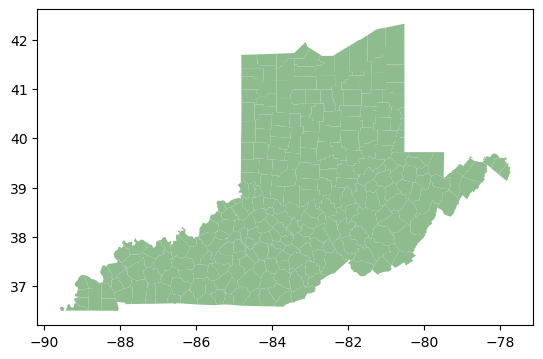

In [22]:
counties12.plot(color='darkseagreen');

In [23]:
corn = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\Corn Acreage Yield 1990-2024.csv')

In [24]:
corn_condition = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\CORN-CropCondition.csv')

In [25]:
hay = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\Hay Acreage Yield 1990-2024.csv')

In [26]:
soybean = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\Soybeans Acreage Yield 1990-2024.csv')

In [27]:
soy_condition = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\SOYBEANS-CropCondition.csv')

In [28]:
wheat_condition = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\WHEAT-CropCondition.csv')

In [29]:
kyweather = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\KY Weather 1990-2024.csv')

In [30]:
ohweather = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\Ohio Weather 1990-2024.csv')

In [31]:
wvweather = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\WV Weather 1990-2024.csv')

In [32]:
kyweather['DATE'] = pd.to_datetime(kyweather['DATE'], errors='coerce')

In [33]:
kyweather['Year'] = kyweather['DATE'].dt.year

In [34]:
ky_maxtemp_year = kyweather.groupby('Year')['Max Temp'].max().reset_index()

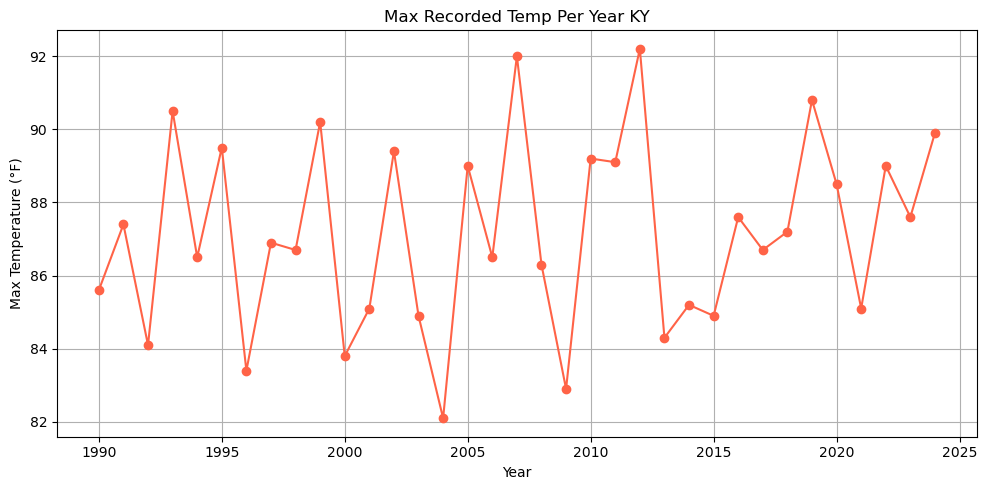

In [35]:
plt.figure(figsize=(10,5))
plt.plot(ky_maxtemp_year['Year'], ky_maxtemp_year['Max Temp'], color='tomato', marker='o')
plt.title('Max Recorded Temp Per Year KY')
plt.xlabel('Year')
plt.ylabel('Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
ky_extmaxtemp_year = kyweather.groupby('Year')['Ext Max Temp'].max().reset_index()

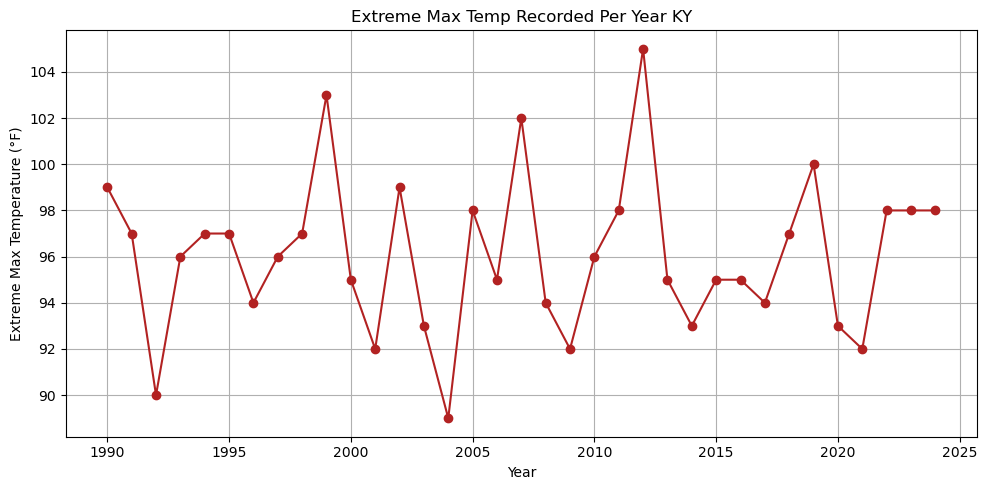

In [37]:
plt.figure(figsize=(10,5))
plt.plot(ky_extmaxtemp_year['Year'],ky_extmaxtemp_year['Ext Max Temp'], color='firebrick', marker='o')
plt.title('Extreme Max Temp Recorded Per Year KY')
plt.xlabel('Year')
plt.ylabel('Extreme Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
ohweather['DATE'] = pd.to_datetime(ohweather['DATE'], errors='coerce')

In [39]:
ohweather['Year'] = ohweather['DATE'].dt.year

In [40]:
oh_maxtemp_year = ohweather.groupby('Year')['Max Temp'].max().reset_index()

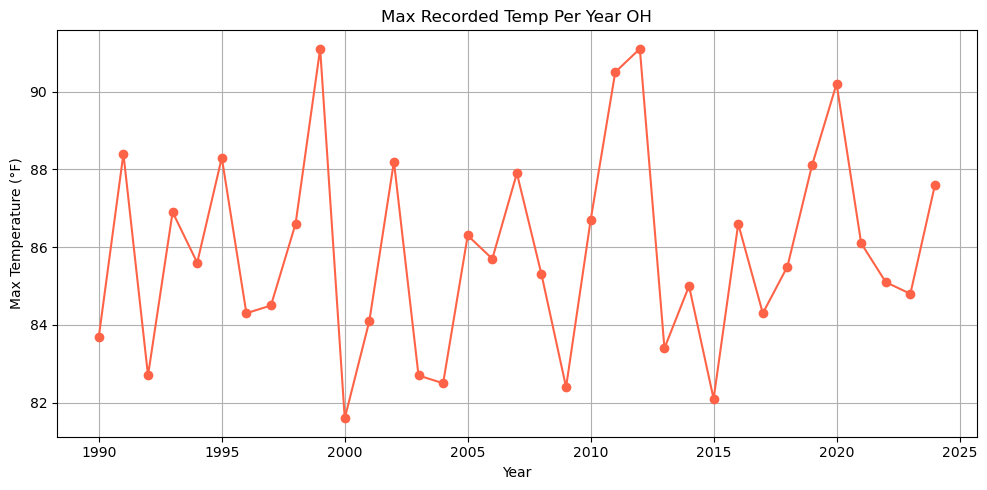

In [41]:
plt.figure(figsize=(10,5))
plt.plot(oh_maxtemp_year['Year'], oh_maxtemp_year['Max Temp'], color='tomato', marker='o')
plt.title('Max Recorded Temp Per Year OH')
plt.xlabel('Year')
plt.ylabel('Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
oh_extmaxtemp_year = ohweather.groupby('Year')['Ext Max Temp'].max().reset_index()

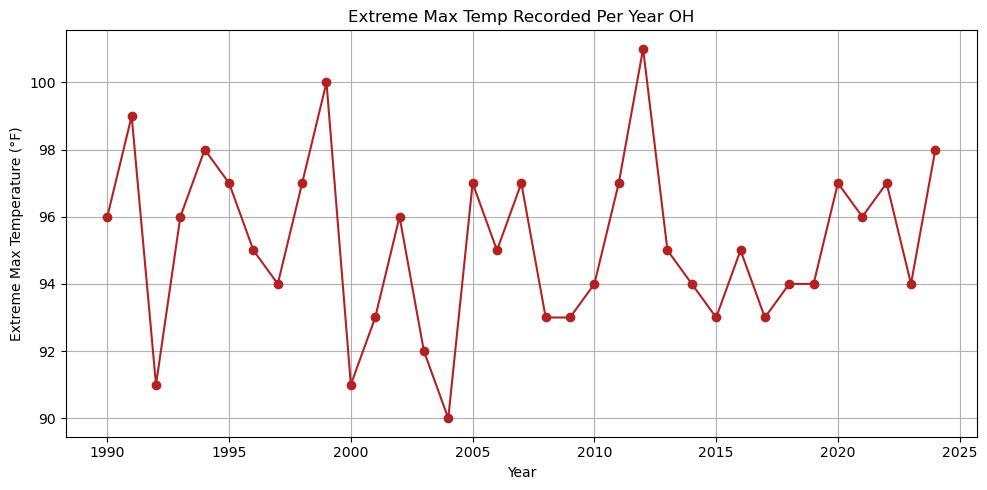

In [43]:
plt.figure(figsize=(10,5))
plt.plot(oh_extmaxtemp_year['Year'], oh_extmaxtemp_year['Ext Max Temp'], color='firebrick', marker='o')
plt.title('Extreme Max Temp Recorded Per Year OH')
plt.xlabel('Year')
plt.ylabel('Extreme Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
wvweather['DATE'] = pd.to_datetime(wvweather['DATE'], errors='coerce')

In [45]:
wvweather['Year'] = wvweather['DATE'].dt.year

In [46]:
wv_maxtemp_year = wvweather.groupby('Year')['Max Temp'].max().reset_index()

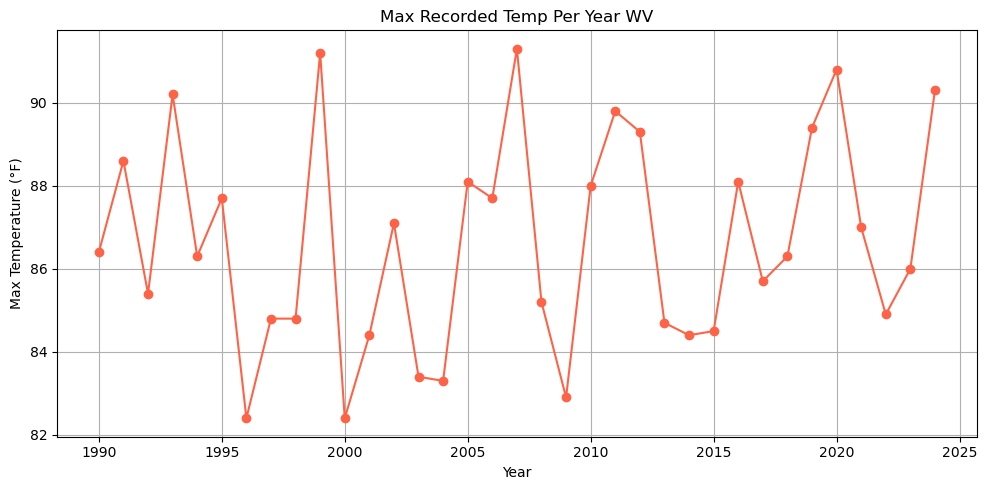

In [47]:
plt.figure(figsize=(10,5))
plt.plot(wv_maxtemp_year['Year'], wv_maxtemp_year['Max Temp'], color='tomato', marker='o')
plt.title('Max Recorded Temp Per Year WV')
plt.xlabel('Year')
plt.ylabel('Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
wv_extmaxtemp_year = wvweather.groupby('Year')['Ext Max Temp'].max().reset_index()

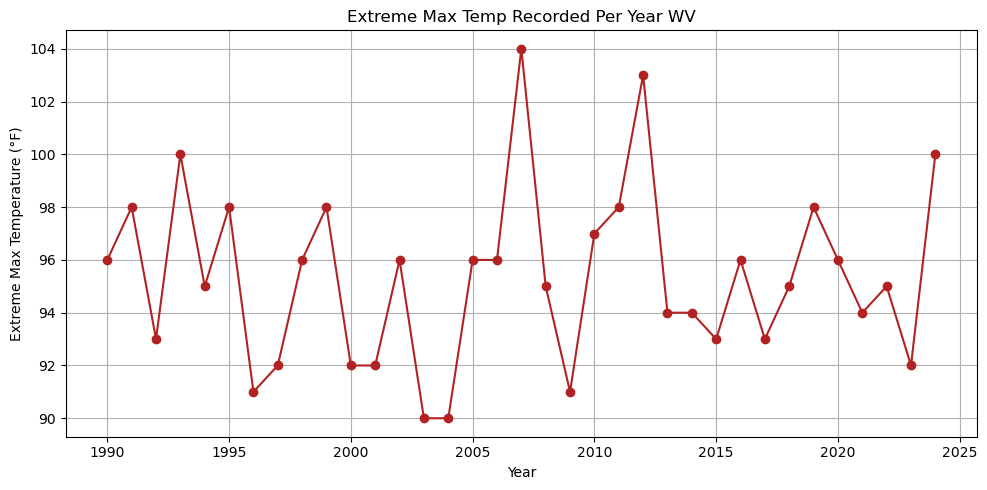

In [49]:
plt.figure(figsize=(10,5))
plt.plot(wv_extmaxtemp_year['Year'], wv_extmaxtemp_year['Ext Max Temp'], color='firebrick', marker='o')
plt.title('Extreme Max Temp Recorded Per Year WV')
plt.xlabel('Year')
plt.ylabel('Extreme Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
wvweather['Decade'] = (wvweather['Year'] // 10) * 10

In [51]:
kyweather['Decade'] = (kyweather['Year'] // 10) * 10

In [52]:
ohweather['Decade'] = (ohweather['Year'] // 10) * 10

In [53]:
ky_avgtemp_dec = kyweather.groupby('Decade')['Avg Temp'].mean().reset_index()

In [54]:
import seaborn as sns
import numpy as np

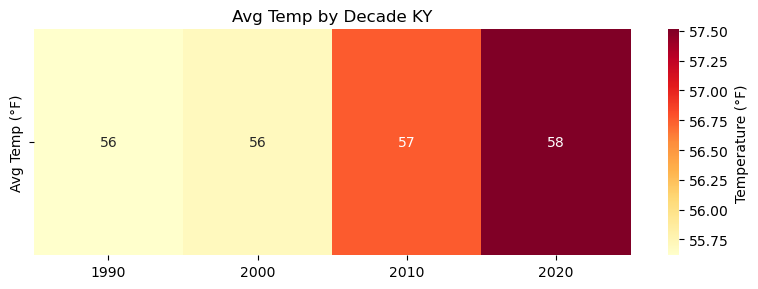

In [55]:
data = np.array([ky_avgtemp_dec['Avg Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='YlOrRd', xticklabels=ky_avgtemp_dec['Decade'], 
            yticklabels=['Avg Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Temp by Decade KY')
plt.tight_layout()
plt.show()

In [56]:
ky_avgextmax_dec = kyweather.groupby('Decade')['Ext Max Temp'].mean().reset_index()

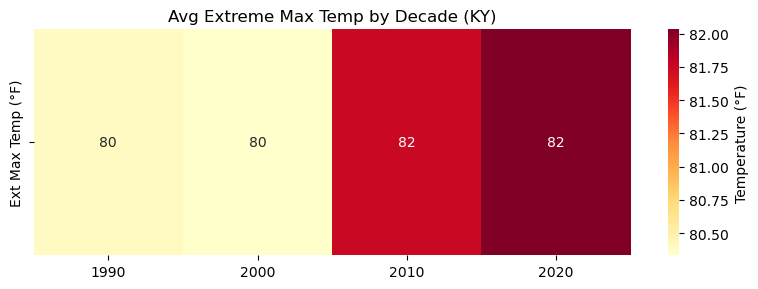

In [57]:
data = np.array([ky_avgextmax_dec['Ext Max Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True,  fmt='.0f', cmap='YlOrRd', xticklabels=ky_avgextmax_dec['Decade'], 
            yticklabels=['Ext Max Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Extreme Max Temp by Decade (KY)')
plt.tight_layout()
plt.show()

In [58]:
oh_avgtemp_dec = ohweather.groupby('Decade')['Avg Temp'].mean().reset_index()

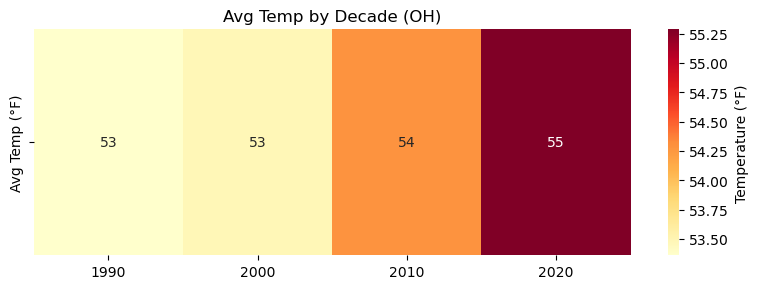

In [59]:
data = np.array([oh_avgtemp_dec['Avg Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='YlOrRd', xticklabels=oh_avgtemp_dec['Decade'], 
            yticklabels=['Avg Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Temp by Decade (OH)')
plt.tight_layout()
plt.show()

In [60]:
oh_avgextmax_dec = ohweather.groupby('Decade')['Ext Max Temp'].mean().reset_index()

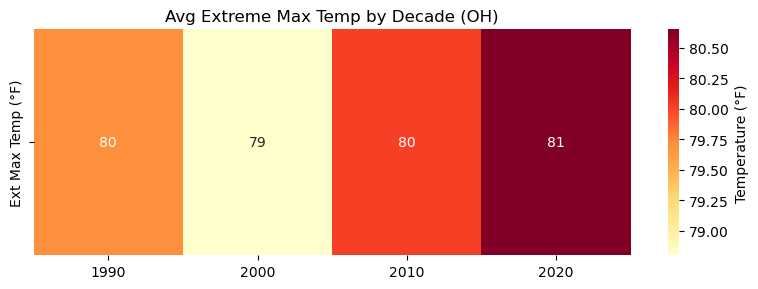

In [61]:
data = np.array([oh_avgextmax_dec['Ext Max Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='YlOrRd', xticklabels=oh_avgextmax_dec['Decade'], 
            yticklabels=['Ext Max Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Extreme Max Temp by Decade (OH)')
plt.tight_layout()
plt.show()

In [62]:
wv_avgtemp_dec = wvweather.groupby('Decade')['Avg Temp'].mean().reset_index()

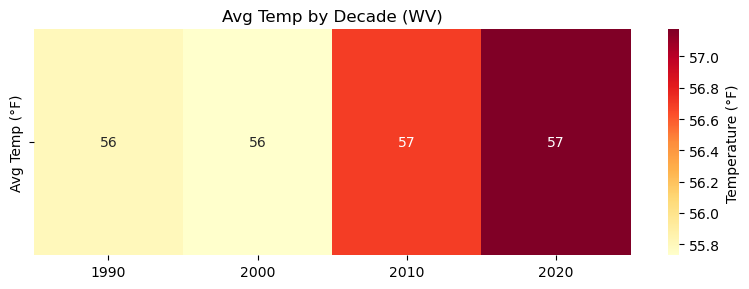

In [63]:
data = np.array([wv_avgtemp_dec['Avg Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='YlOrRd', xticklabels=wv_avgtemp_dec['Decade'], 
            yticklabels=['Avg Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Temp by Decade (WV)')
plt.tight_layout()
plt.show()

In [64]:
wv_avgextmax_dec = wvweather.groupby('Decade')['Ext Max Temp'].mean().reset_index()

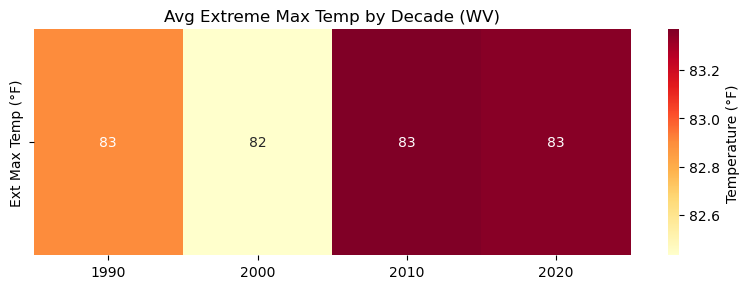

In [65]:
data = np.array([wv_avgextmax_dec['Ext Max Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='YlOrRd', xticklabels=wv_avgextmax_dec['Decade'], 
            yticklabels=['Ext Max Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Extreme Max Temp by Decade (WV)')
plt.tight_layout()
plt.show()

In [66]:
tristate_weather = pd.concat([wvweather, ohweather, kyweather], ignore_index=True)

tristate_weather.head()

,STATION,NAME,DATE,DSND,DSNW,Ext Min Temp,Ext Max Snow Depth,Ext Max Snowfall,Ext Max Prec,Ext Max Temp,PRCP,SNOW,Avg Temp,Max Temp,Min Temp,Year,Decade
0,USW00013866,CHARLESTON WEST VIRGINIA INTERNATIONAL YEAGER ...,1990-01-01,2.0,2.0,19.0,5.0,7.4,1.15,65.0,2.87,11.0,42.3,51.9,32.7,1990,1990
1,USW00013866,CHARLESTON WEST VIRGINIA INTERNATIONAL YEAGER ...,1990-02-01,1.0,1.0,6.0,1.0,2.9,0.84,77.0,3.74,3.8,45.2,56.9,33.4,1990,1990
2,USW00013866,CHARLESTON WEST VIRGINIA INTERNATIONAL YEAGER ...,1990-03-01,2.0,2.0,23.0,2.0,3.3,0.56,89.0,1.94,6.6,51.7,62.7,40.6,1990,1990
3,USW00013866,CHARLESTON WEST VIRGINIA INTERNATIONAL YEAGER ...,1990-04-01,0.0,0.0,25.0,0.0,0.8,0.71,94.0,2.89,1.1,55.0,68.1,42.0,1990,1990
4,USW00013866,CHARLESTON WEST VIRGINIA INTERNATIONAL YEAGER ...,1990-05-01,0.0,0.0,41.0,0.0,0.0,0.95,88.0,4.87,0.0,62.9,73.1,52.7,1990,1990


In [67]:
tristate_yearly = (
    tristate_weather
    .groupby('Year', as_index=True)
    .mean(numeric_only=True)
    .sort_index()
)

tristate_yearly.head()

,DSND,DSNW,Ext Min Temp,Ext Max Snow Depth,Ext Max Snowfall,Ext Max Prec,Ext Max Temp,PRCP,SNOW,Avg Temp,Max Temp,Min Temp,Decade
Year,,,,,,,,,,,,,
1990,0.500000,0.333333,29.944444,0.500000,0.777778,1.258333,82.527778,4.149722,1.200000,56.555556,66.847222,46.269444,1990.0
1991,0.750000,0.388889,30.388889,0.583333,0.588889,1.124444,81.000000,3.251667,1.097222,56.880556,66.983333,46.772222,1990.0
1992,1.111111,0.444444,28.277778,0.583333,0.861111,1.159444,79.027778,3.579167,1.519444,54.186111,63.577778,44.775000,1990.0
1993,1.944444,0.750000,28.916667,1.500000,1.586111,1.132222,80.444444,3.477500,3.016667,54.347222,64.075000,44.616667,1990.0
1994,2.305556,0.611111,28.027778,1.277778,1.263889,1.169167,81.166667,3.521667,2.697222,54.530556,65.069444,43.994444,1990.0


In [68]:
tristate_weather['Year'] = pd.to_numeric(tristate_weather['Year'], errors='coerce').astype('Int64')

for col in ['Max Temp', 'Ext Max Temp']:
    if col in tristate_weather.columns:
        tristate_weather[col] = pd.to_numeric(tristate_weather[col], errors='coerce')

In [69]:
tristate_yearly = (
    tristate_weather
    .groupby('Year', as_index=True)[['Max Temp', 'Ext Max Temp']]
    .mean()
    .sort_index()
    .dropna(how='all')
)

In [70]:
from sklearn.linear_model import LinearRegression

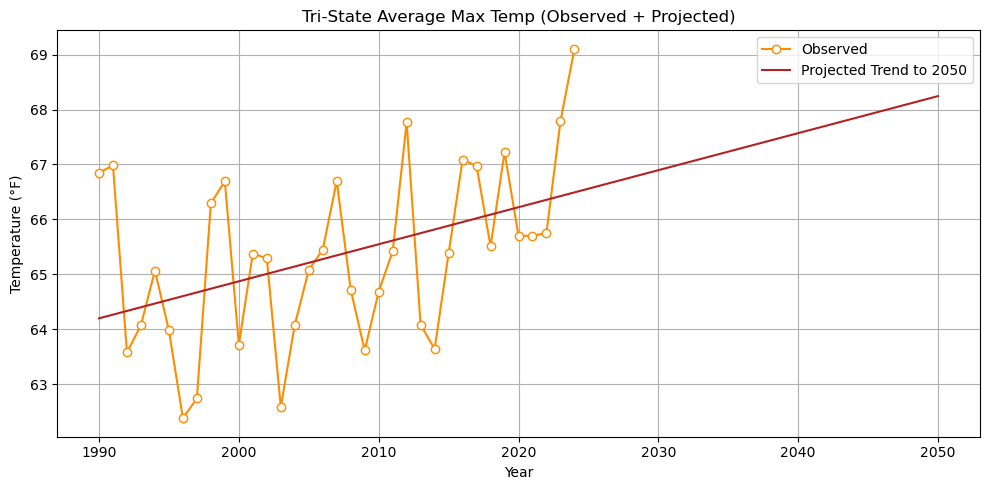

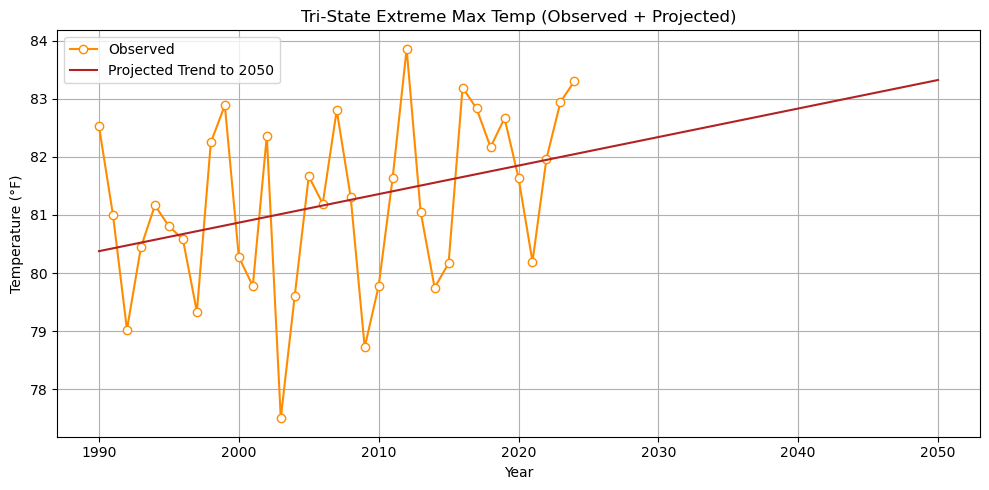

In [71]:
def project_and_plot(series, title):
    s = series.dropna().sort_index()
    if len(s) < 2:
        print(f"Not enough data to fit a trend for: {title} (n={len(s)})")
        return

    X = s.index.to_numpy().reshape(-1, 1) 
    y = s.to_numpy()

    model = LinearRegression().fit(X, y)
    years_future = np.arange(int(s.index.min()), 2051)
    preds = model.predict(years_future.reshape(-1, 1))

    plt.figure(figsize=(10, 5))
    plt.plot(s.index, s.values, color='darkorange', marker='o', mec='darkorange', mfc='white', label='Observed')
    plt.plot(years_future, preds, color='firebrick', label='Projected Trend to 2050')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Temperature (°F)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

project_and_plot(tristate_yearly['Max Temp'], 'Tri-State Average Max Temp (Observed + Projected)')
project_and_plot(tristate_yearly['Ext Max Temp'], 'Tri-State Extreme Max Temp (Observed + Projected)')

In [72]:
for col in ['Min Temp', 'Ext Min Temp']:
    if col in tristate_weather.columns:
        tristate_weather[col] = pd.to_numeric(tristate_weather[col], errors='coerce')

In [73]:
tristate_yearly_min = (
    tristate_weather
      .groupby('Year', as_index=True)[['Min Temp','Ext Min Temp']]
      .min()
      .sort_index()
      .dropna(how='all')
)

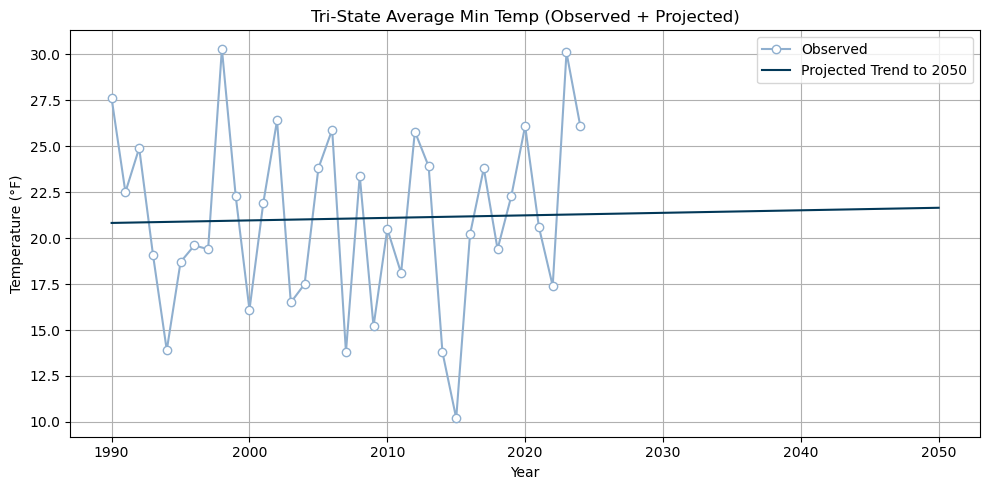

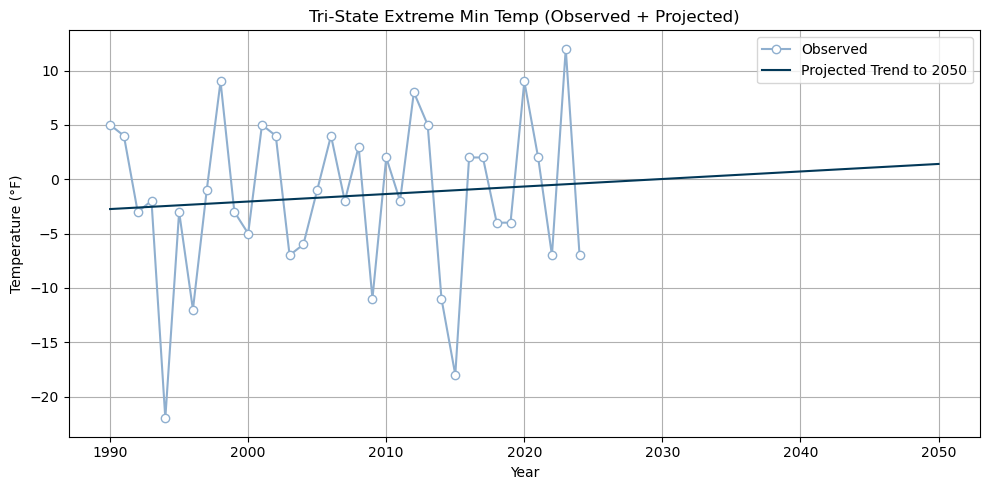

In [74]:
def project_and_plot2(series, title):
    s2 = series.dropna().sort_index()
    if len(s2) < 2:
        print(f"Not enough data to fit a trend for: {title} (n={len(s2)})")
        return

    X2 = s2.index.to_numpy().reshape(-1, 1) 
    y2 = s2.to_numpy()

    model2 = LinearRegression().fit(X2, y2)
    years_future2 = np.arange(int(s2.index.min()), 2051)
    preds2 = model2.predict(years_future2.reshape(-1, 1))

    plt.figure(figsize=(10, 5))
    plt.plot(s2.index, s2.values, color='#8fafcf', marker='o', mec='#8fafcf', mfc='white', label='Observed')
    plt.plot(years_future2, preds2, color='#023858', label='Projected Trend to 2050')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Temperature (°F)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

project_and_plot2(tristate_yearly_min['Min Temp'], 'Tri-State Average Min Temp (Observed + Projected)')
project_and_plot2(tristate_yearly_min['Ext Min Temp'], 'Tri-State Extreme Min Temp (Observed + Projected)')

In [75]:
tristate_maxtemp_year = tristate_weather.groupby('Year')['Max Temp'].max().reset_index()

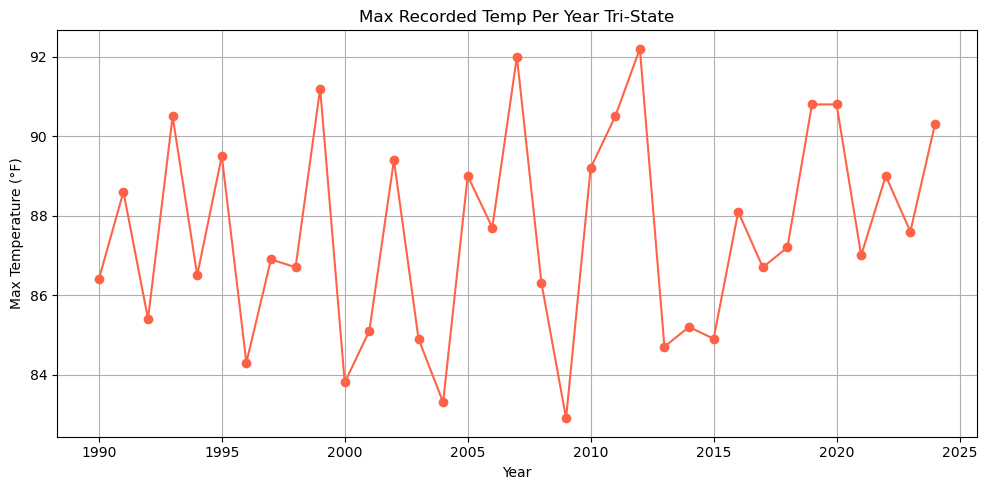

In [76]:
plt.figure(figsize=(10,5))
plt.plot(tristate_maxtemp_year['Year'], tristate_maxtemp_year['Max Temp'], color='tomato', marker='o')
plt.title('Max Recorded Temp Per Year Tri-State')
plt.xlabel('Year')
plt.ylabel('Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
tristate_extmaxtemp_year = tristate_weather.groupby('Year')['Ext Max Temp'].max().reset_index()

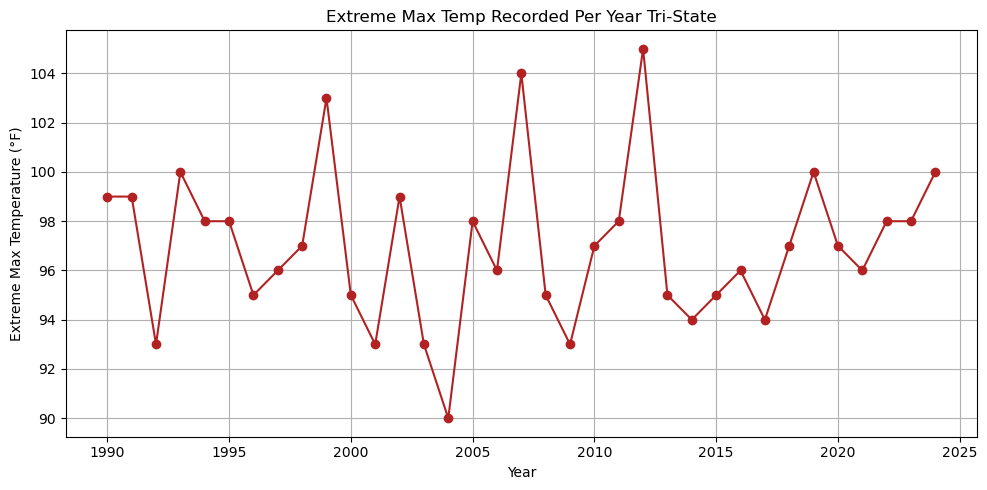

In [78]:
plt.figure(figsize=(10,5))
plt.plot(tristate_extmaxtemp_year['Year'], tristate_extmaxtemp_year['Ext Max Temp'], color='firebrick', marker='o')
plt.title('Extreme Max Temp Recorded Per Year Tri-State')
plt.xlabel('Year')
plt.ylabel('Extreme Max Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
tristate_extmintemp_year = tristate_weather.groupby('Year')['Ext Min Temp'].min().reset_index()

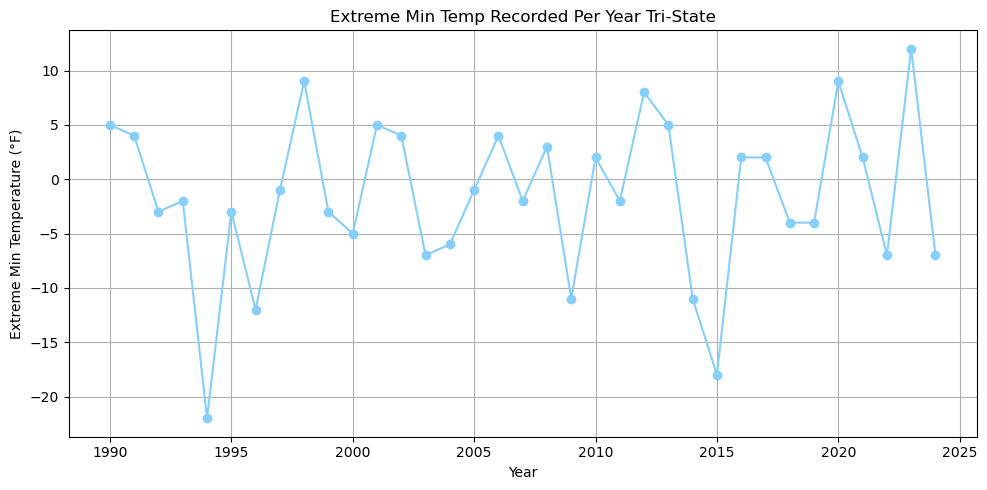

In [80]:
plt.figure(figsize=(10,5))
plt.plot(tristate_extmintemp_year['Year'], tristate_extmintemp_year['Ext Min Temp'], color='lightskyblue', marker='o')
plt.title('Extreme Min Temp Recorded Per Year Tri-State')
plt.xlabel('Year')
plt.ylabel('Extreme Min Temperature (°F)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
ts_avgtemp_dec = tristate_weather.groupby('Decade')['Avg Temp'].mean().reset_index()

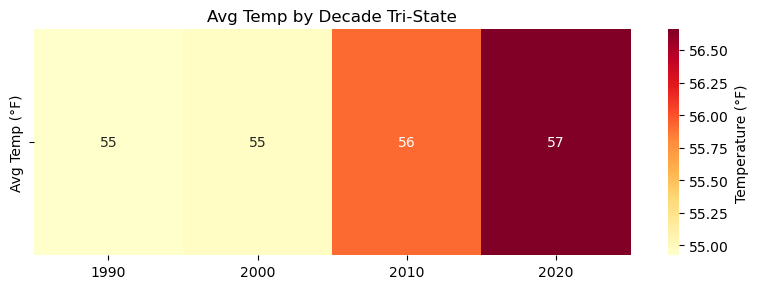

In [82]:
data = np.array([ts_avgtemp_dec['Avg Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='YlOrRd', xticklabels=ts_avgtemp_dec['Decade'], 
            yticklabels=['Avg Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Temp by Decade Tri-State')
plt.tight_layout()
plt.show()

In [83]:
ts_avgextmax_dec = tristate_weather.groupby('Decade')['Ext Max Temp'].mean().reset_index()

In [85]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

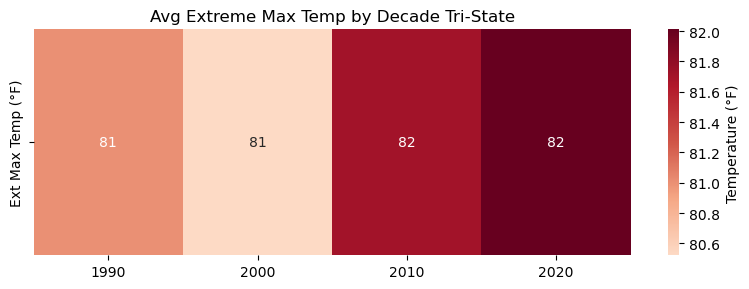

In [86]:
data = np.array([ts_avgextmax_dec['Ext Max Temp']])

colors = ["#fddac5", "#f5a785", "#d05548", "#b1182b", "#67001f"]
custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", colors, N=256)

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap=custom_cmap, xticklabels=ts_avgextmax_dec['Decade'], 
            yticklabels=['Ext Max Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Extreme Max Temp by Decade Tri-State')
plt.tight_layout()
plt.show()

In [87]:
ts_extmax_dec = tristate_weather.groupby('Decade')['Ext Max Temp'].max().reset_index()

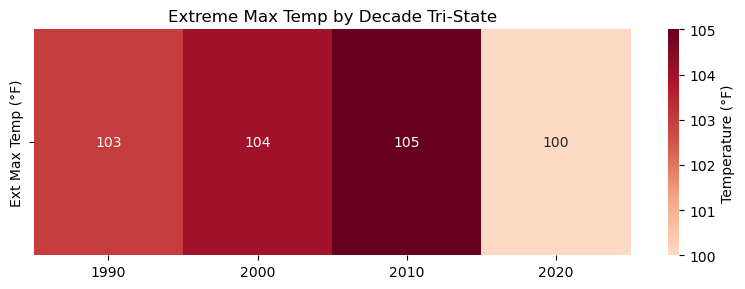

In [88]:
data = np.array([ts_extmax_dec['Ext Max Temp']])

colors = ["#fddac5", "#f5a785", "#d05548", "#b1182b", "#67001f"]
custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", colors, N=256)

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap=custom_cmap, xticklabels=ts_extmax_dec['Decade'], 
            fmt='.0f', yticklabels=['Ext Max Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Extreme Max Temp by Decade Tri-State')
plt.tight_layout()
plt.show()

In [89]:
ts_avgextmin_dec = tristate_weather.groupby('Decade')['Ext Min Temp'].mean().reset_index()

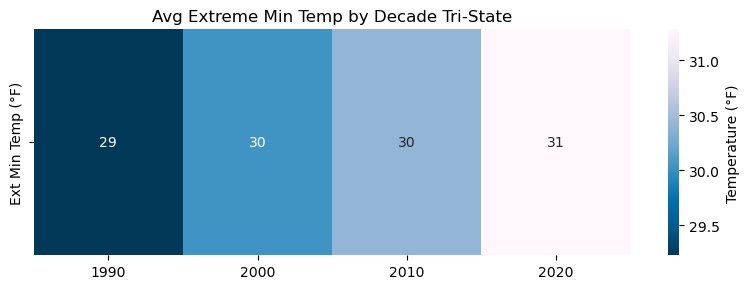

In [90]:
data = np.array([ts_avgextmin_dec['Ext Min Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='PuBu_r', xticklabels=ts_avgextmin_dec['Decade'], 
            yticklabels=['Ext Min Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Avg Extreme Min Temp by Decade Tri-State')
plt.tight_layout()
plt.show()

In [91]:
ts_extmin_dec = tristate_weather.groupby('Decade')['Ext Min Temp'].min().reset_index()

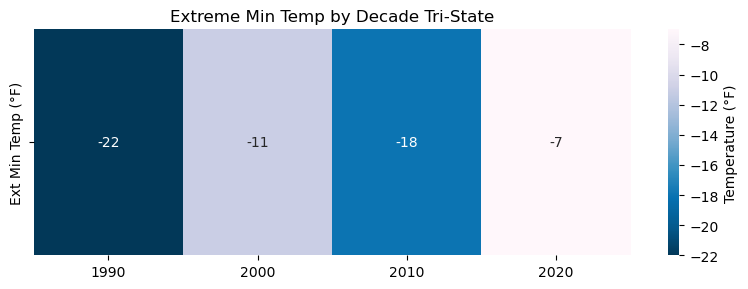

In [92]:
data = np.array([ts_extmin_dec['Ext Min Temp']])

plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, cmap='PuBu_r', xticklabels=ts_extmin_dec['Decade'], 
            yticklabels=['Ext Min Temp (°F)'], cbar_kws={'label': 'Temperature (°F)'})

plt.title('Extreme Min Temp by Decade Tri-State')
plt.tight_layout()
plt.show()

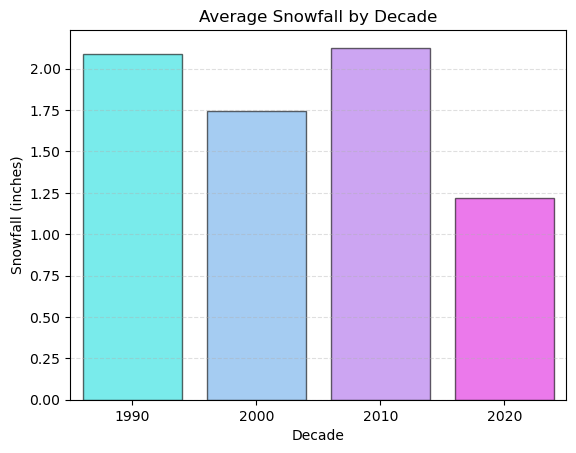

In [93]:
decade_snowfall = tristate_weather.groupby('Decade')['SNOW'].mean().reset_index()

sns.barplot(data=decade_snowfall, x='Decade', y='SNOW', order=decade_snowfall['Decade'], edgecolor = 'black', hue = 'Decade', legend = False, palette = 'cool', errorbar=None, alpha=0.6)
plt.title("Average Snowfall by Decade")
plt.ylabel("Snowfall (inches)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

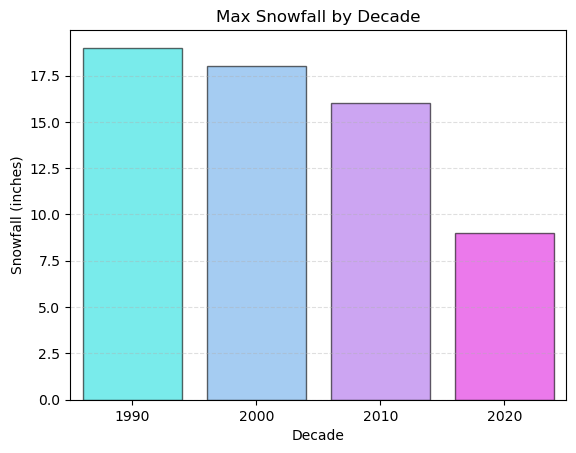

In [94]:
decade_emsd = tristate_weather.groupby('Decade')['Ext Max Snow Depth'].max().reset_index()

sns.barplot(data=decade_emsd, x='Decade', y='Ext Max Snow Depth', order=decade_emsd['Decade'], edgecolor = 'black', hue = 'Decade', legend = False, palette = 'cool', errorbar=None, alpha=0.6)
plt.title("Max Snowfall by Decade")
plt.ylabel("Snowfall (inches)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

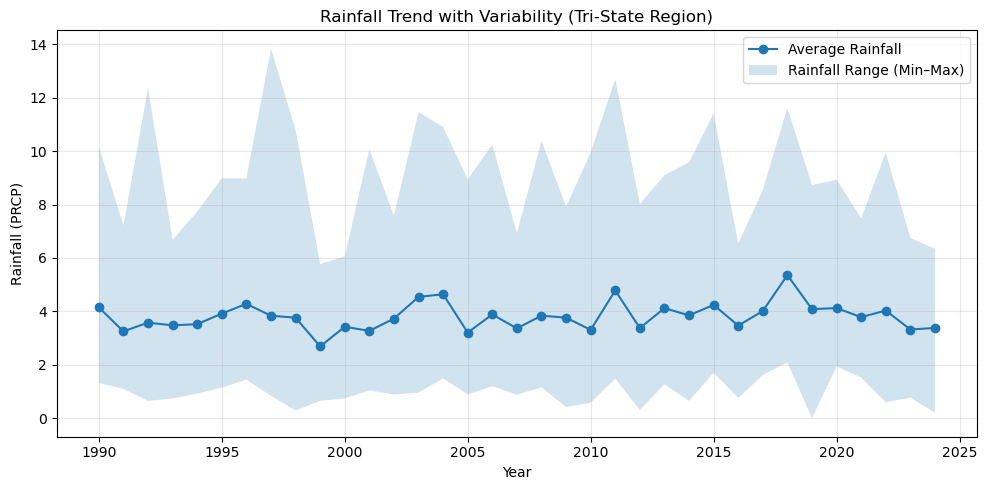

In [175]:
rain = tristate_weather.copy()

rain['Year'] = pd.to_numeric(rain['Year'], errors='coerce')
rain['PRCP'] = pd.to_numeric(rain['PRCP'], errors='coerce')

rain = rain.dropna(subset=['Year', 'PRCP'])

rainfall = rain.groupby('Year').agg(
    Avg_Rainfall=('PRCP', 'mean'),
    Min_Rainfall=('PRCP', 'min'),
    Max_Rainfall=('PRCP', 'max')
).reset_index()

plt.figure(figsize=(10,5))
plt.plot(rainfall['Year'], rainfall['Avg_Rainfall'], label='Average Rainfall', marker='o')
plt.fill_between(rainfall['Year'], rainfall['Min_Rainfall'], 
                 rainfall['Max_Rainfall'], alpha=0.2, label='Rainfall Range (Min–Max)')
plt.title('Rainfall Trend with Variability (Tri-State Region)')
plt.xlabel('Year')
plt.ylabel('Rainfall (PRCP)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

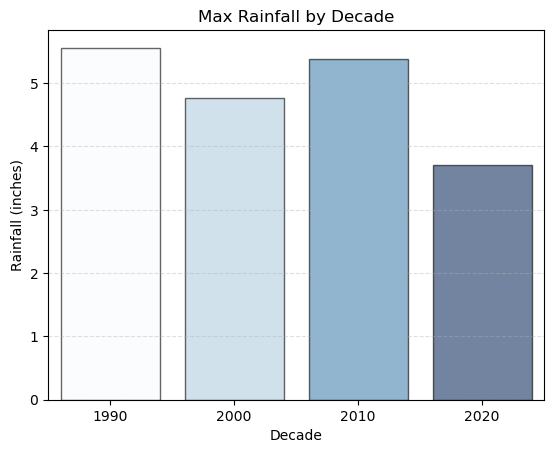

In [96]:
decade_emrain = tristate_weather.groupby('Decade')['Ext Max Prec'].max().reset_index()

sns.barplot(data=decade_emrain, x='Decade', y='Ext Max Prec', order=decade_emrain['Decade'], edgecolor = 'black', hue = 'Decade', legend = False, palette = 'Blues', errorbar=None, alpha=0.6)
plt.title("Max Rainfall by Decade")
plt.ylabel("Rainfall (inches)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [97]:
corn.columns

Index(['YEAR', 'LOCATION', 'STATE ANSI', 'ASD CODE', 'COUNTY ANSI',
       'REFERENCE PERIOD', 'COMMODITY', 'AREA HARVESTED in ACRES',
       'PRODUCTION in $', 'PRODUCTION in BU', 'YIELD in BU / ACRE',
       'PRODUCTION in TONS', 'YIELD in TONS / ACRE', 'AREA PLANTED in ACRES',
       'PRICE RECEIVED in $ / BU'],
      dtype='object')

In [98]:
corn['YEAR'] = corn['YEAR'].astype(int)
corn['DECADE'] = (corn['YEAR'] // 10) * 10

In [99]:
corn['AREA PLANTED in ACRES'] = pd.to_numeric(corn['AREA PLANTED in ACRES'], errors='coerce')

In [100]:
corn_ky = corn[corn['LOCATION'] == 'KENTUCKY']

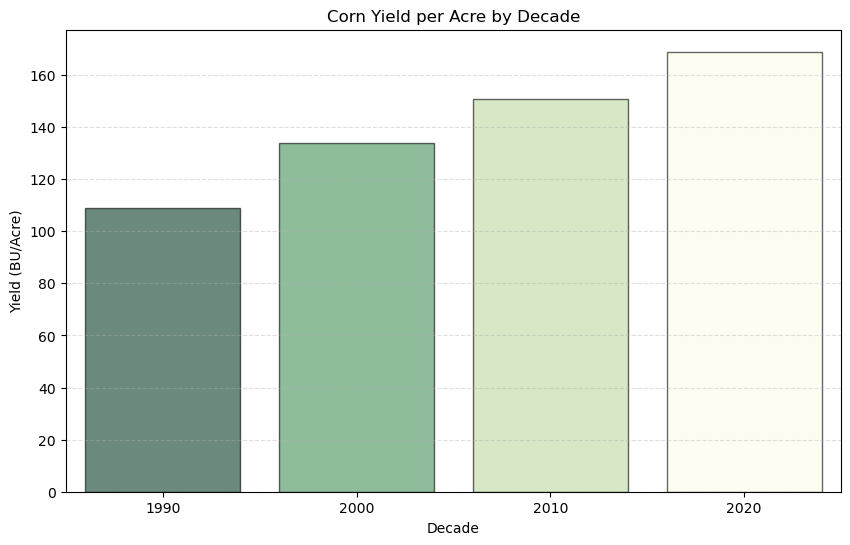

In [101]:
plt.figure(figsize=(10, 6))
sns.barplot(data=corn, x='DECADE', y='YIELD in BU / ACRE', order=corn['DECADE'], edgecolor = 'black', hue = 'DECADE', legend = False, palette = 'YlGn_r', errorbar=None, alpha=0.6)
plt.title("Corn Yield per Acre by Decade")
plt.ylabel("Yield (BU/Acre)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [102]:
hay['YEAR'] = hay['YEAR'].astype(int)
hay['DECADE'] = (hay['YEAR'] // 10) * 10

In [103]:
hay

,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,PRODN PRACTICE,AREA HARVESTED in ACRES,PRODUCTION in $,PRODUCTION in TONS,YIELD in TONS / ACRE,DECADE
0,1990,KENTUCKY,21,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"2,200,000","350,232,000","4,848,000",2.20,1990
1,1990,OHIO,39,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"1,400,000","425,460,000","4,620,000",3.30,1990
2,1990,WEST VIRGINIA,54,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"560,000","80,086,000","1,142,000",2.04,1990
3,1991,KENTUCKY,21,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"2,300,000","368,425,000","5,125,000",2.23,1990
4,1991,OHIO,39,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"1,300,000","327,705,000","3,150,000",2.42,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2023,OHIO,39,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"810,000","423,657,000","2,457,000",3.03,2020
101,2023,WEST VIRGINIA,54,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"610,000","154,224,000","1,051,000",1.72,2020
102,2024,KENTUCKY,21,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"2,100,000","898,200,000","5,000,000",2.38,2020
103,2024,OHIO,39,,,YEAR,HAY,ALL PRODUCTION PRACTICES,"790,000","348,717,000","1,911,000",2.42,2020


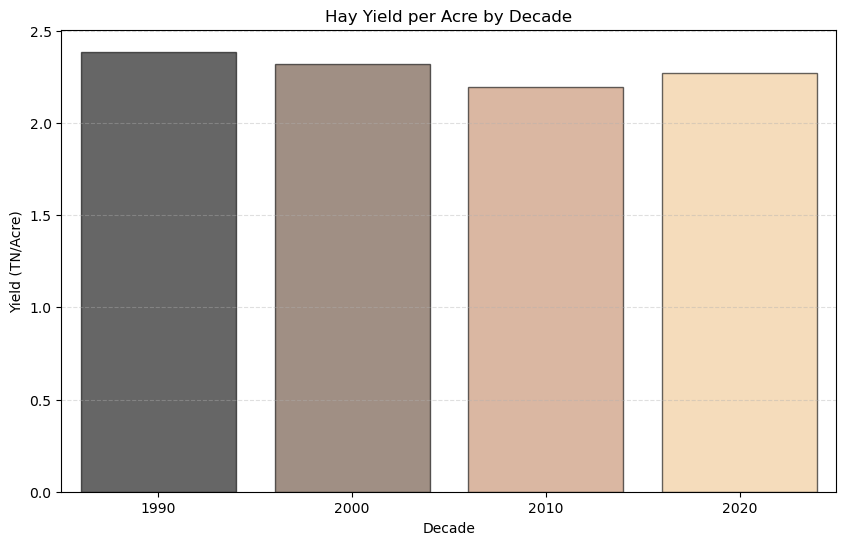

In [104]:
plt.figure(figsize=(10, 6))
sns.barplot(data=hay, x='DECADE', y='YIELD in TONS / ACRE', order=hay['DECADE'], edgecolor = 'black', hue = 'DECADE', legend = False, palette = 'copper', errorbar=None, alpha=0.6)
plt.title("Hay Yield per Acre by Decade")
plt.ylabel("Yield (TN/Acre)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [105]:
soybean['YEAR'] = soybean['YEAR'].astype(int)
soybean['DECADE'] = (soybean['YEAR'] // 10) * 10

In [106]:
soybean

,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,AREA HARVESTED in ACRES,AREA PLANTED in ACRES,PRODUCTION in $,PRODUCTION in BU,YIELD in BU / ACRE,PRICE RECEIVED in $ / BU,DECADE
0,1990,KENTUCKY,21,,,YEAR,SOYBEANS,"1,220,000","1,250,000","228,774,000","39,040,000",32.0,5.86,1990
1,1990,OHIO,39,,,YEAR,SOYBEANS,"3,480,000","3,500,000","788,533,000","135,720,000",39.0,5.81,1990
2,1991,KENTUCKY,21,,,YEAR,SOYBEANS,"1,130,000","1,150,000","212,271,000","36,725,000",32.5,5.78,1990
3,1991,OHIO,39,,,YEAR,SOYBEANS,"3,770,000","3,800,000","772,247,000","135,720,000",36.0,5.69,1990
4,1992,KENTUCKY,21,,,YEAR,SOYBEANS,"1,110,000","1,130,000","239,582,000","42,180,000",38.0,5.68,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2022,OHIO,39,,,YEAR,SOYBEANS,"5,080,000","5,100,000","4,059,936,000","281,940,000",55.5,14.40,2020
85,2023,KENTUCKY,21,,,YEAR,SOYBEANS,"1,820,000","1,830,000","1,281,280,000","100,100,000",55.0,12.80,2020
86,2023,OHIO,39,,,YEAR,SOYBEANS,"4,730,000","4,750,000","3,429,250,000","274,340,000",58.0,12.50,2020
87,2024,KENTUCKY,21,,,YEAR,SOYBEANS,"2,030,000","2,050,000","1,037,952,000","97,440,000",48.0,10.50,2020


In [107]:
soybeans = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\Soybeans Acreage Yield 1990-2024.csv')

In [108]:
soybeans['YEAR'] = soybeans['YEAR'].astype(int)
soybeans['DECADE'] = (soybeans['YEAR'] // 10) * 10

In [109]:
soybeans

,YEAR,LOCATION,STATE ANSI,ASD CODE,COUNTY ANSI,REFERENCE PERIOD,COMMODITY,AREA HARVESTED in ACRES,AREA PLANTED in ACRES,PRODUCTION in $,PRODUCTION in BU,YIELD in BU / ACRE,PRICE RECEIVED in $ / BU,DECADE
0,1990,KENTUCKY,21,,,YEAR,SOYBEANS,"1,220,000","1,250,000","228,774,000","39,040,000",32.0,5.86,1990
1,1990,OHIO,39,,,YEAR,SOYBEANS,"3,480,000","3,500,000","788,533,000","135,720,000",39.0,5.81,1990
2,1991,KENTUCKY,21,,,YEAR,SOYBEANS,"1,130,000","1,150,000","212,271,000","36,725,000",32.5,5.78,1990
3,1991,OHIO,39,,,YEAR,SOYBEANS,"3,770,000","3,800,000","772,247,000","135,720,000",36.0,5.69,1990
4,1992,KENTUCKY,21,,,YEAR,SOYBEANS,"1,110,000","1,130,000","239,582,000","42,180,000",38.0,5.68,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2022,OHIO,39,,,YEAR,SOYBEANS,"5,080,000","5,100,000","4,059,936,000","281,940,000",55.5,14.40,2020
85,2023,KENTUCKY,21,,,YEAR,SOYBEANS,"1,820,000","1,830,000","1,281,280,000","100,100,000",55.0,12.80,2020
86,2023,OHIO,39,,,YEAR,SOYBEANS,"4,730,000","4,750,000","3,429,250,000","274,340,000",58.0,12.50,2020
87,2024,KENTUCKY,21,,,YEAR,SOYBEANS,"2,030,000","2,050,000","1,037,952,000","97,440,000",48.0,10.50,2020


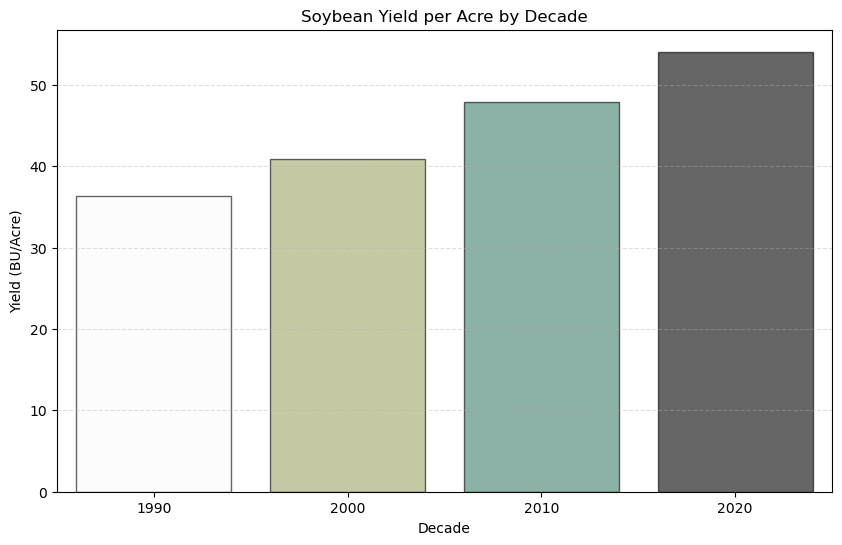

In [110]:
plt.figure(figsize=(10, 6))
sns.barplot(data=soybeans, x='DECADE', y='YIELD in BU / ACRE', order=soybean['DECADE'], edgecolor = 'black', hue = 'DECADE', legend = False, palette = 'gist_earth_r', errorbar=None, alpha=0.6)
plt.title("Soybean Yield per Acre by Decade")
plt.ylabel("Yield (BU/Acre)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [111]:
soybeans['AREA PLANTED in ACRES'] = (
    soybeans['AREA PLANTED in ACRES']
        .str.replace(',', '', regex=False)   
        .astype(float)                       
)

print(soybeans['AREA PLANTED in ACRES'].head(), soybeans['AREA PLANTED in ACRES'].dtype)

0    1250000.0
1    3500000.0
2    1150000.0
3    3800000.0
4    1130000.0
Name: AREA PLANTED in ACRES, dtype: float64 float64


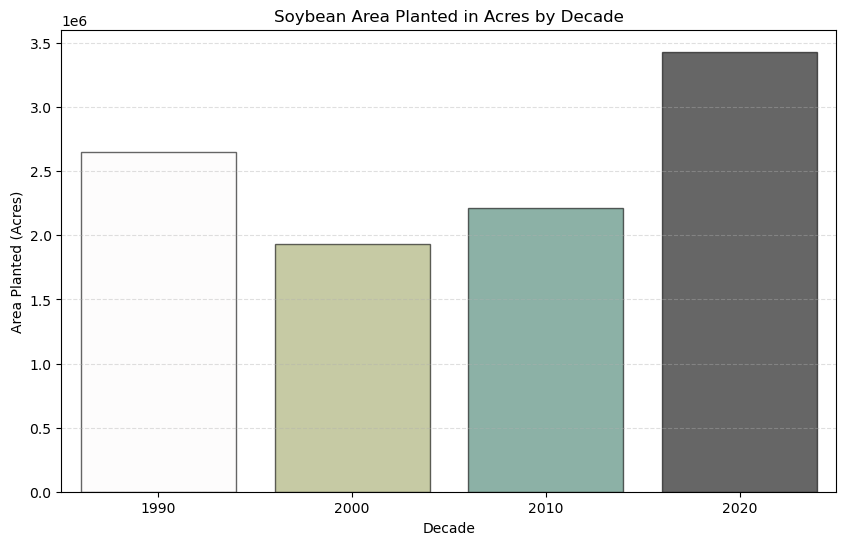

In [112]:
plt.figure(figsize=(10, 6))
sns.barplot(data=soybeans, x='DECADE', y='AREA PLANTED in ACRES', order=soybeans['DECADE'], edgecolor = 'black', hue = 'DECADE', legend = False, palette = 'gist_earth_r', errorbar=None, alpha=0.6)
plt.title("Soybean Area Planted in Acres by Decade")
plt.ylabel("Area Planted (Acres)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [113]:
corn_new = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\Corn Acreage Yield 1990-2024.csv')

In [114]:
corn_new['YEAR'] = corn_new['YEAR'].astype(int)
corn_new['DECADE'] = (corn_new['YEAR'] // 10) * 10

In [115]:
corn_new['AREA PLANTED in ACRES'] = (
    corn_new['AREA PLANTED in ACRES']
        .str.replace(',', '', regex=False)
        .astype(float)                      
)

print(corn_new['AREA PLANTED in ACRES'].head(), corn_new['AREA PLANTED in ACRES'].dtype)

0    1350000.0
1    3700000.0
2      90000.0
3    1400000.0
4    3700000.0
Name: AREA PLANTED in ACRES, dtype: float64 float64


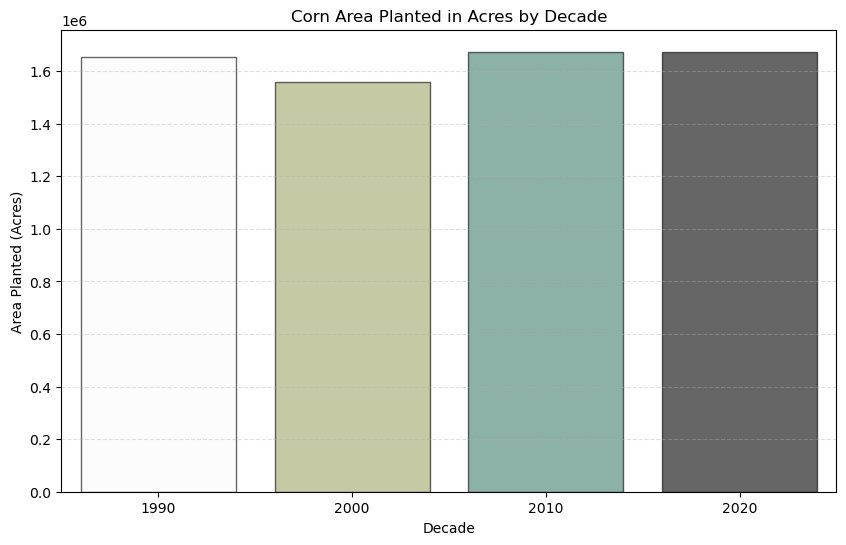

In [116]:
plt.figure(figsize=(10, 6))
sns.barplot(data=corn_new, x='DECADE', y='AREA PLANTED in ACRES', order=corn_new['DECADE'], edgecolor = 'black', hue = 'DECADE', legend = False, palette = 'gist_earth_r', errorbar=None, alpha=0.6)
plt.title("Corn Area Planted in Acres by Decade")
plt.ylabel("Area Planted (Acres)")
plt.xlabel("Decade")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [117]:
corn_condition.columns

Index(['YEAR', 'LOCATION', 'STATE ANSI', 'ASD CODE', 'COUNTY ANSI',
       'REFERENCE PERIOD', 'COMMODITY', 'CONDITION in PCT POOR',
       'CONDITION in PCT FAIR', 'CONDITION in PCT VERY POOR',
       'CONDITION in PCT GOOD', 'CONDITION in PCT EXCELLENT',
       'CONDITION, 5 YEAR AVG in PCT EXCELLENT',
       'CONDITION, 5 YEAR AVG in PCT VERY POOR',
       'CONDITION, 5 YEAR AVG in PCT POOR',
       'CONDITION, 5 YEAR AVG in PCT GOOD',
       'CONDITION, 5 YEAR AVG in PCT FAIR',
       'CONDITION, PREVIOUS YEAR in PCT FAIR',
       'CONDITION, PREVIOUS YEAR in PCT EXCELLENT',
       'CONDITION, PREVIOUS YEAR in PCT VERY POOR',
       'CONDITION, PREVIOUS YEAR in PCT POOR',
       'CONDITION, PREVIOUS YEAR in PCT GOOD'],
      dtype='object')

In [118]:
use = corn_condition.copy()

for c in ['CONDITION in PCT EXCELLENT','CONDITION in PCT GOOD',
          'CONDITION in PCT POOR','CONDITION in PCT VERY POOR',
          'CONDITION, PREVIOUS YEAR in PCT EXCELLENT',
          'CONDITION, PREVIOUS YEAR in PCT GOOD']:
    use[c] = pd.to_numeric(use[c], errors='coerce')

In [119]:
yearly = (use.groupby('YEAR', as_index=True)
            [['CONDITION in PCT EXCELLENT','CONDITION in PCT GOOD']].mean())

yearly['Good+Excellent'] = yearly['CONDITION in PCT EXCELLENT'] + yearly['CONDITION in PCT GOOD']

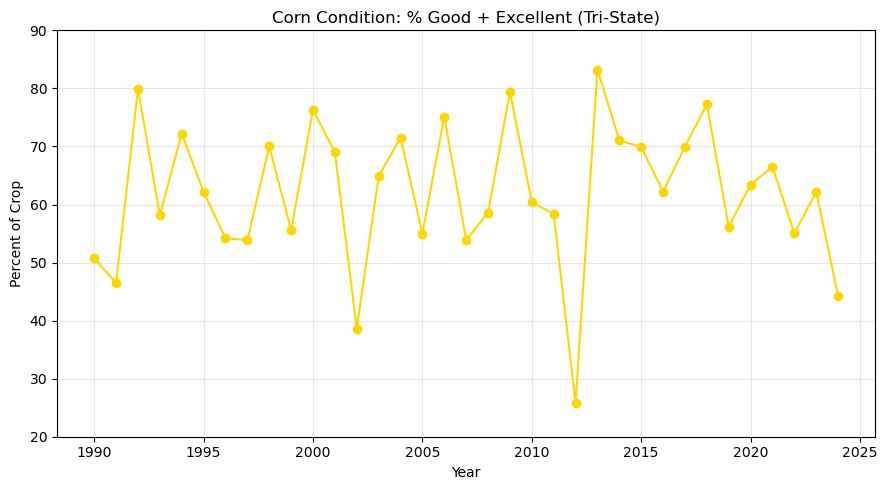

In [120]:
plt.figure(figsize=(9,5))
plt.plot(yearly.index, yearly['Good+Excellent'], marker='o', color='gold')
plt.title('Corn Condition: % Good + Excellent (Tri-State)')
plt.ylabel('Percent of Crop')
plt.xlabel('Year')
plt.ylim(20, 90)
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()

In [121]:
use2 = soy_condition.copy()

for c in ['CONDITION in PCT EXCELLENT','CONDITION in PCT GOOD',
          'CONDITION in PCT POOR','CONDITION in PCT VERY POOR',
          'CONDITION, PREVIOUS YEAR in PCT EXCELLENT',
          'CONDITION, PREVIOUS YEAR in PCT GOOD']:
    use2[c] = pd.to_numeric(use[c], errors='coerce')

In [122]:
yearly_soy = (use2.groupby('YEAR', as_index=True)
            [['CONDITION in PCT EXCELLENT','CONDITION in PCT GOOD']].mean())

yearly_soy['Good+Excellent'] = yearly_soy['CONDITION in PCT EXCELLENT'] + yearly_soy['CONDITION in PCT GOOD']

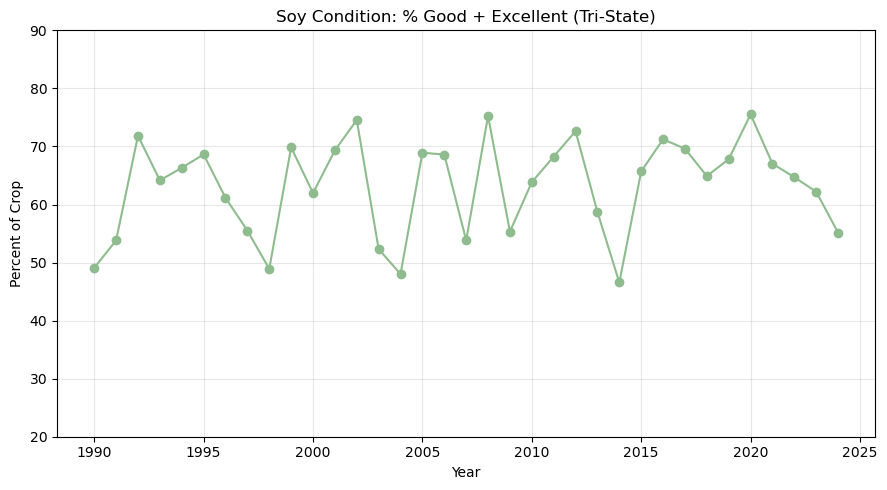

In [123]:
plt.figure(figsize=(9,5))
plt.plot(yearly_soy.index, yearly_soy['Good+Excellent'], marker='o', color='darkseagreen')
plt.title('Soy Condition: % Good + Excellent (Tri-State)')
plt.ylabel('Percent of Crop')
plt.xlabel('Year')
plt.ylim(20, 90)
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()

In [124]:
use3 = wheat_condition.copy()

for c in ['CONDITION in PCT EXCELLENT','CONDITION in PCT GOOD',
          'CONDITION in PCT POOR','CONDITION in PCT VERY POOR',
          'CONDITION, PREVIOUS YEAR in PCT EXCELLENT',
          'CONDITION, PREVIOUS YEAR in PCT GOOD']:
    use3[c] = pd.to_numeric(use[c], errors='coerce')

In [125]:
yearly_wheat = (use3.groupby('YEAR', as_index=True)
            [['CONDITION in PCT EXCELLENT','CONDITION in PCT GOOD']].mean())

yearly_wheat['Good+Excellent'] = yearly_wheat['CONDITION in PCT EXCELLENT'] + yearly_wheat['CONDITION in PCT GOOD']

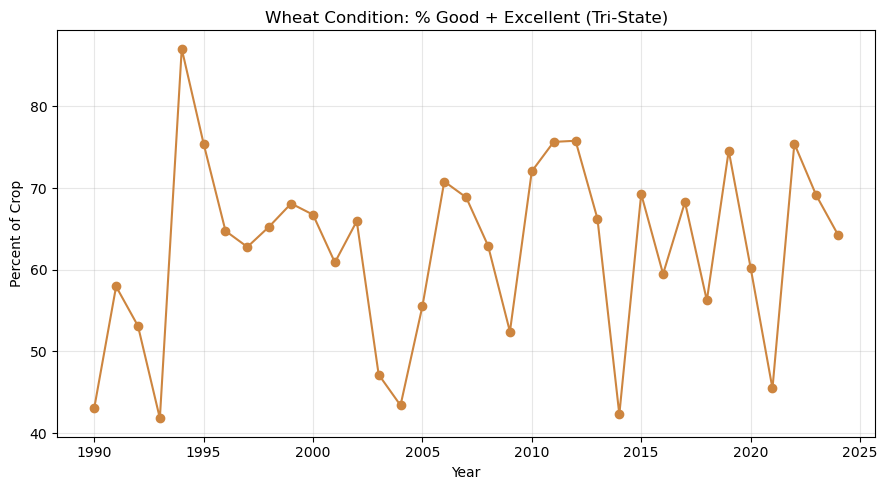

In [126]:
plt.figure(figsize=(9,5))
plt.plot(yearly_wheat.index, yearly_wheat['Good+Excellent'], marker='o',color='peru')
plt.title('Wheat Condition: % Good + Excellent (Tri-State)')
plt.ylabel('Percent of Crop')
plt.xlabel('Year')
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()

In [127]:
mergedcorn = pd.merge(corn, tristate_weather, left_on=['YEAR'], right_on=['Year'], how='inner')

In [128]:
correlation_corn = mergedcorn['Avg Temp'].corr(mergedcorn['YIELD in BU / ACRE'])
print("Correlation between temperature and crop yield:", correlation_corn)

Correlation between temperature and crop yield: 0.014487469557998766


In [129]:
correlation_rain = mergedcorn['PRCP'].corr(mergedcorn['YIELD in BU / ACRE'])
print("Correlation between precipitation and crop yield:", correlation_rain)

Correlation between precipitation and crop yield: 0.08265105860941596


In [130]:
mergedsoy = pd.merge(soybeans, tristate_weather, left_on=['YEAR'], right_on=['Year'], how='inner')

In [131]:
correlation_soy = mergedsoy['Avg Temp'].corr(mergedsoy['YIELD in BU / ACRE'])
print("Correlation between temperature and crop yield:", correlation_soy)

Correlation between temperature and crop yield: 0.020276173461873367


In [132]:
import re

wx = tristate_weather.copy()

wx['Year'] = pd.to_datetime(wx['DATE'], errors='coerce').dt.year

def extract_state(s):
    if pd.isna(s): return np.nan
    # last 2-letter token, e.g., "... HUNTINGTON WV" -> WV
    m = re.search(r'\b([A-Z]{2})\b', str(s).upper())
    return m.group(1) if m else np.nan

wx['STATE_ABBR'] = wx['STATION'].apply(extract_state)
mask_na = wx['STATE_ABBR'].isna()
wx.loc[mask_na, 'STATE_ABBR'] = wx.loc[mask_na, 'NAME'].apply(extract_state)

num_cols = ['PRCP','SNOW','Avg Temp','Max Temp','Min Temp','Ext Max Temp','Ext Min Temp']
for c in num_cols:
    wx[c] = pd.to_numeric(wx[c], errors='coerce')

wx_state_year = (wx
    .groupby(['STATE_ABBR','Year'], as_index=False)
    .agg({
        'PRCP': 'sum',          # or 'mean' if your PRCP is already monthly/annual
        'SNOW': 'sum',
        'Avg Temp': 'mean',
        'Max Temp': 'mean',     # or 'max' depending on your question
        'Min Temp': 'mean',
        'Ext Max Temp': 'max',
        'Ext Min Temp': 'min'
    })
)

assert not wx_state_year.duplicated(['STATE_ABBR','Year']).any()
wx_state_year.head()

C:\Users\user\AppData\Local\Temp\ipykernel_23692\2973857149.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['WV' 'WV' 'WV' ... 'KY' 'KY' 'KY']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  wx.loc[mask_na, 'STATE_ABBR'] = wx.loc[mask_na, 'NAME'].apply(extract_state)


,STATE_ABBR,Year,PRCP,SNOW,Avg Temp,Max Temp,Min Temp,Ext Max Temp,Ext Min Temp
0,KY,1990,52.17,4.7,57.041667,66.791667,47.300000,99.0,10.0
1,KY,1991,41.81,5.2,57.275000,66.775000,47.750000,97.0,4.0
2,KY,1992,49.11,7.3,55.116667,64.150000,46.066667,90.0,2.0
3,KY,1993,45.61,26.5,54.950000,64.400000,45.525000,96.0,3.0
4,KY,1994,45.74,24.2,55.408333,65.441667,45.366667,97.0,-20.0


In [133]:
corn = corn.copy()

state_map = {
    'WEST VIRGINIA':'WV', 'OHIO':'OH', 'KENTUCKY':'KY', 'INDIANA':'IN',
    'West Virginia':'WV', 'Ohio':'OH', 'Kentucky':'KY', 'Indiana':'IN'
}
corn['STATE_ABBR'] = corn['LOCATION'].replace(state_map).str.upper()

corn['Year'] = pd.to_numeric(corn['YEAR'], errors='coerce').astype('Int64')

corn_keep = corn[['STATE_ABBR','Year','YIELD in BU / ACRE','AREA PLANTED in ACRES',
                  'PRODUCTION in BU']].copy()

corn_keep = (corn_keep
             .groupby(['STATE_ABBR','Year'], as_index=False)
             .agg({'YIELD in BU / ACRE':'mean',
                   'AREA PLANTED in ACRES':'sum',
                   'PRODUCTION in BU':'sum'}))

assert not corn_keep.duplicated(['STATE_ABBR','Year']).any()
corn_keep.head()

,STATE_ABBR,Year,YIELD in BU / ACRE,AREA PLANTED in ACRES,PRODUCTION in BU
0,KY,1990,100.0,0.0,"120,000,000"
1,KY,1991,89.0,0.0,"111,250,000"
2,KY,1992,132.0,0.0,"171,600,000"
3,KY,1993,104.0,0.0,"126,880,000"
4,KY,1994,128.0,0.0,"156,160,000"


In [134]:
merged_corn = corn_keep.merge(wx_state_year,
                             on=['STATE_ABBR','Year'],
                             how='left',
                             validate='m:1')  

print(merged_corn.shape)
print(merged_corn[['STATE_ABBR','Year']].drop_duplicates().shape)


(105, 12)
(105, 2)


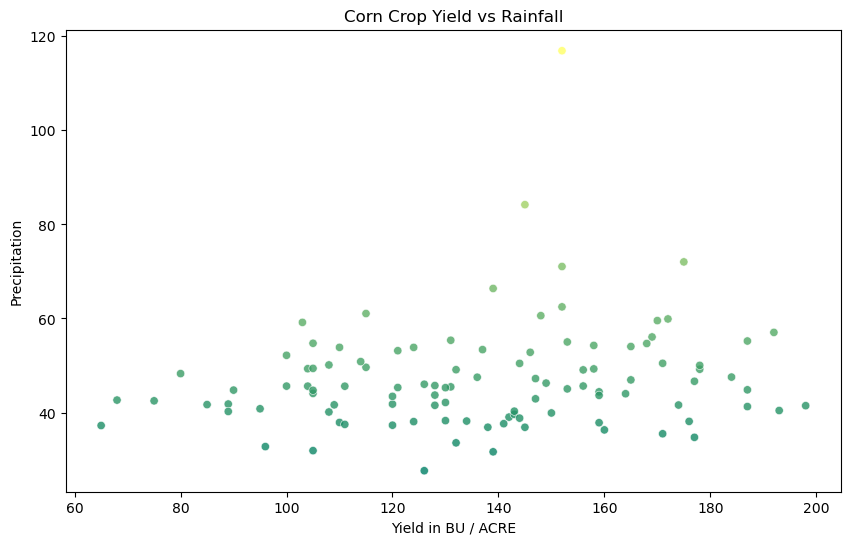

In [135]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='YIELD in BU / ACRE', y='PRCP', data=merged_corn, hue='PRCP', alpha=0.8, palette='summer', legend=False)
plt.xlabel("Yield in BU / ACRE")
plt.ylabel("Precipitation")
plt.title("Corn Crop Yield vs Rainfall")
plt.show()

In [136]:
merged_corn.columns

Index(['STATE_ABBR', 'Year', 'YIELD in BU / ACRE', 'AREA PLANTED in ACRES',
       'PRODUCTION in BU', 'PRCP', 'SNOW', 'Avg Temp', 'Max Temp', 'Min Temp',
       'Ext Max Temp', 'Ext Min Temp'],
      dtype='object')

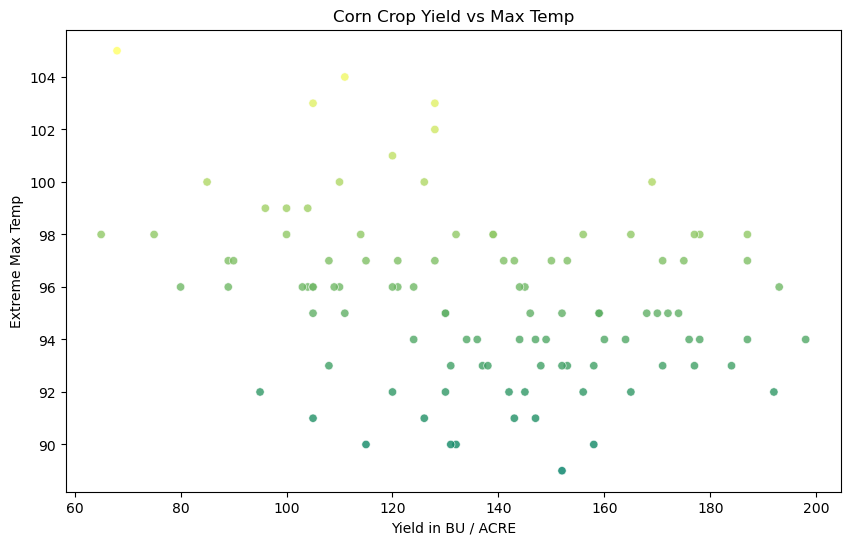

In [137]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='YIELD in BU / ACRE', y='Ext Max Temp', data=merged_corn, hue='Ext Max Temp', alpha=0.8, palette='summer', legend=False)
plt.xlabel("Yield in BU / ACRE")
plt.ylabel("Extreme Max Temp")
plt.title("Corn Crop Yield vs Max Temp")
plt.show()

In [138]:
soy = soybeans.copy()

soy['STATE_ABBR'] = soy['LOCATION'].replace(state_map).str.upper()

soy['Year'] = pd.to_numeric(soy['YEAR'], errors='coerce').astype('Int64')

soy_keep = soy[['STATE_ABBR','Year','YIELD in BU / ACRE','AREA PLANTED in ACRES',
                  'PRODUCTION in BU']].copy()

soy_keep = (soy_keep
             .groupby(['STATE_ABBR','Year'], as_index=False)
             .agg({'YIELD in BU / ACRE':'mean',
                   'AREA PLANTED in ACRES':'sum',
                   'PRODUCTION in BU':'sum'}))

assert not soy_keep.duplicated(['STATE_ABBR','Year']).any()
soy_keep.head()

,STATE_ABBR,Year,YIELD in BU / ACRE,AREA PLANTED in ACRES,PRODUCTION in BU
0,KY,1990,32.0,1250000.0,"39,040,000"
1,KY,1991,32.5,1150000.0,"36,725,000"
2,KY,1992,38.0,1130000.0,"42,180,000"
3,KY,1993,33.0,1180000.0,"37,950,000"
4,KY,1994,37.5,1150000.0,"42,375,000"


In [139]:
merged_soy = soy_keep.merge(wx_state_year,
                             on=['STATE_ABBR','Year'],
                             how='left',
                             validate='m:1') 

print(merged_soy.shape)
print(merged_soy[['STATE_ABBR','Year']].drop_duplicates().shape)

(89, 12)
(89, 2)


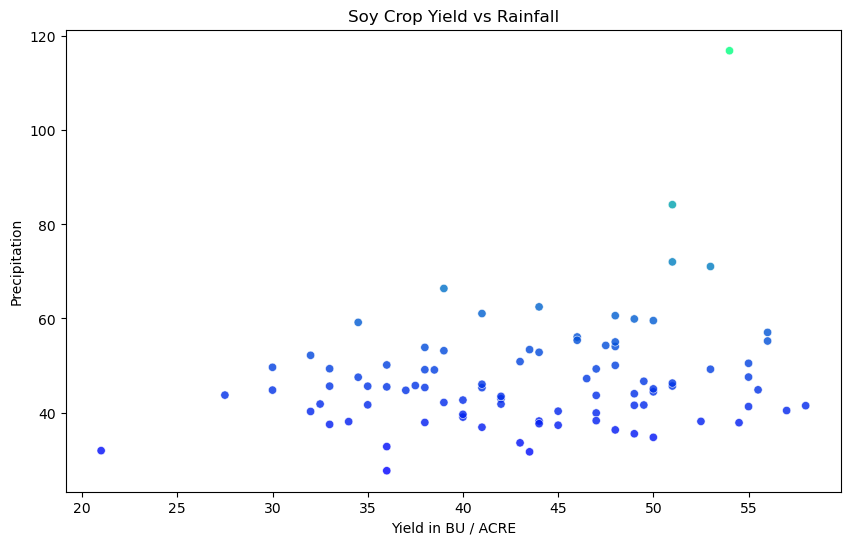

In [140]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='YIELD in BU / ACRE', y='PRCP', data=merged_soy, hue='PRCP', alpha=0.8, palette='winter', legend=False)
plt.xlabel("Yield in BU / ACRE")
plt.ylabel("Precipitation")
plt.title("Soy Crop Yield vs Rainfall")
plt.show()

In [141]:
tristate_weather.to_csv('tristate_weather.csv')

In [142]:
drought = pd.read_csv(r'C:\Users\user\workspace\c11\Python\projects\MHow682-capstone\data\Drought 1990-2024.csv')

In [143]:
drought.columns

Index(['FIPS', 'StartDate', 'EndDate', 'ConsecutiveWeeks', 'State', 'County'], dtype='object')

In [144]:
drought['StartDate'] = pd.to_datetime(drought['StartDate'])
drought['EndDate'] = pd.to_datetime(drought['EndDate'])

rows = []

for _, row in drought.iterrows():
    start = row['StartDate']
    end = row['EndDate']
    total_weeks = row['ConsecutiveWeeks']
    state = row['State']

    if start.year == end.year:
        rows.append({'Year': start.year, 'State': state, 'Weeks': total_weeks})
    else:
        end_of_year = pd.Timestamp(year=start.year, month=12, day=31)
        weeks_in_start_year = ((end_of_year - start).days // 7) + 1

        weeks_in_next_year = total_weeks - weeks_in_start_year

        rows.append({'Year': start.year, 'State': state, 'Weeks': weeks_in_start_year})
        rows.append({'Year': start.year + 1, 'State': state, 'Weeks': weeks_in_next_year})

drought_split = pd.DataFrame(rows)

In [145]:
drought_split

,Year,State,Weeks
0,2005,KY,5
1,2006,KY,3
2,2007,KY,24
3,2008,KY,15
4,2009,KY,0
...,...,...,...
1684,2002,WV,2
1685,2007,WV,12
1686,2008,WV,9
1687,2019,WV,3


In [146]:
drought_split.to_csv('drought_split.csv')

In [147]:
drought_split['Five_Year_Period'] = (drought_split['Year'] // 5) * 5

In [148]:
drought_split['Period_Label'] = drought_split['Five_Year_Period'].astype(str) + '-' + (drought_split['Five_Year_Period'] + 4).astype(str)
drought_split

,Year,State,Weeks,Five_Year_Period,Period_Label
0,2005,KY,5,2005,2005-2009
1,2006,KY,3,2005,2005-2009
2,2007,KY,24,2005,2005-2009
3,2008,KY,15,2005,2005-2009
4,2009,KY,0,2005,2005-2009
...,...,...,...,...,...
1684,2002,WV,2,2000,2000-2004
1685,2007,WV,12,2005,2005-2009
1686,2008,WV,9,2005,2005-2009
1687,2019,WV,3,2015,2015-2019


In [149]:
drought_asc = drought_split[drought_split['Weeks'] > 0].copy()
drought_asc

,Year,State,Weeks,Five_Year_Period,Period_Label
0,2005,KY,5,2005,2005-2009
1,2006,KY,3,2005,2005-2009
2,2007,KY,24,2005,2005-2009
3,2008,KY,15,2005,2005-2009
5,2012,KY,4,2010,2010-2014
...,...,...,...,...,...
1684,2002,WV,2,2000,2000-2004
1685,2007,WV,12,2005,2005-2009
1686,2008,WV,9,2005,2005-2009
1687,2019,WV,3,2015,2015-2019


In [150]:
drought_asc = drought_asc.sort_values('Period_Label', ascending=True).reset_index()
drought_asc

,index,Year,State,Weeks,Five_Year_Period,Period_Label
0,1361,2002,OH,4,2000,2000-2004
1,943,2001,KY,2,2000,2000-2004
2,944,2002,KY,2,2000,2000-2004
3,333,2002,KY,2,2000,2000-2004
4,332,2001,KY,2,2000,2000-2004
...,...,...,...,...,...,...
1600,966,2023,KY,7,2020,2020-2024
1601,967,2024,KY,2,2020,2020-2024
1602,983,2023,KY,6,2020,2020-2024
1603,1360,2024,OH,3,2020,2020-2024


In [151]:
drought_asc.drop('index', axis=1, inplace=True)
drought_asc

,Year,State,Weeks,Five_Year_Period,Period_Label
0,2002,OH,4,2000,2000-2004
1,2001,KY,2,2000,2000-2004
2,2002,KY,2,2000,2000-2004
3,2002,KY,2,2000,2000-2004
4,2001,KY,2,2000,2000-2004
...,...,...,...,...,...
1600,2023,KY,7,2020,2020-2024
1601,2024,KY,2,2020,2020-2024
1602,2023,KY,6,2020,2020-2024
1603,2024,OH,3,2020,2020-2024


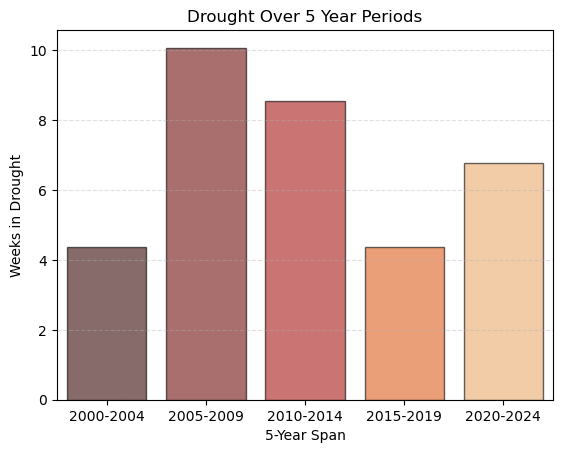

In [152]:
sns.barplot(data=drought_asc, x='Period_Label', y='Weeks', order=drought_asc['Period_Label'], edgecolor = 'black', hue = 'Period_Label', legend = False, palette = 'gist_heat', errorbar=None, alpha=0.6)
plt.title("Drought Over 5 Year Periods")
plt.ylabel("Weeks in Drought")
plt.xlabel("5-Year Span")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [153]:
counties_2012 = gpd.sjoin(counties, zones12_std[['ZONE', 'geometry']], how='left', predicate='intersects')
counties_2023 = gpd.sjoin(counties, zones23_std[['ZONE', 'geometry']], how='left', predicate='intersects')

counties_2012 = counties_2012[['NAME', 'STATEFP', 'ZONE']].rename(columns={'ZONE':'ZONE_2012'})
counties_2023 = counties_2023[['NAME', 'STATEFP', 'ZONE']].rename(columns={'ZONE':'ZONE_2023'})

zones_change = counties_2012.merge(counties_2023, on=['NAME','STATEFP'])


In [154]:
zones_change['ZONE_2012_NUM'] = zones_change['ZONE_2012'].str.extract(r'(\d+)').astype(float)
zones_change['ZONE_2023_NUM'] = zones_change['ZONE_2023'].str.extract(r'(\d+)').astype(float)

zones_change['Change'] = zones_change['ZONE_2023_NUM'] - zones_change['ZONE_2012_NUM']

zones_change['ChangeType'] = zones_change['Change'].apply(
    lambda x: 'Shifted Warmer' if x > 0 else ('Shifted Cooler' if x < 0 else 'Unchanged')
)

In [155]:
zones_summary = (
    zones_change.groupby(['STATEFP', 'ChangeType'])
    .size()
    .reset_index(name='Count')
)

zones_summary['Percent'] = zones_summary.groupby('STATEFP')['Count'].transform(lambda x: 100 * x / x.sum())

In [156]:
state_fips_to_abbrev = {
    '21': 'KY',  # Kentucky
    '39': 'OH',  # Ohio
    '54': 'WV',  # West Virginia
}

In [157]:
zones_summary['State'] = zones_summary['STATEFP'].map(state_fips_to_abbrev)

In [158]:
zones_summary

,STATEFP,ChangeType,Count,Percent,State
0,21,Shifted Cooler,1123,7.595022,KY
1,21,Shifted Warmer,7222,48.843501,KY
2,21,Unchanged,6441,43.561477,KY
3,39,Shifted Cooler,9,0.244233,OH
4,39,Shifted Warmer,2167,58.805970,OH
5,39,Unchanged,1509,40.949796,OH
6,54,Shifted Cooler,1553,5.909887,WV
7,54,Shifted Warmer,12061,45.897709,WV
8,54,Unchanged,12664,48.192404,WV


In [159]:
regional_summary = (
    zones_summary.groupby('ChangeType')['Count']
    .sum()
    .reset_index()
)

regional_summary['Percent'] = (
    regional_summary['Count'] / regional_summary['Count'].sum() * 100
)

print(regional_summary)

       ChangeType  Count    Percent
0  Shifted Cooler   2685   6.000134
1  Shifted Warmer  21450  47.934032
2       Unchanged  20614  46.065834


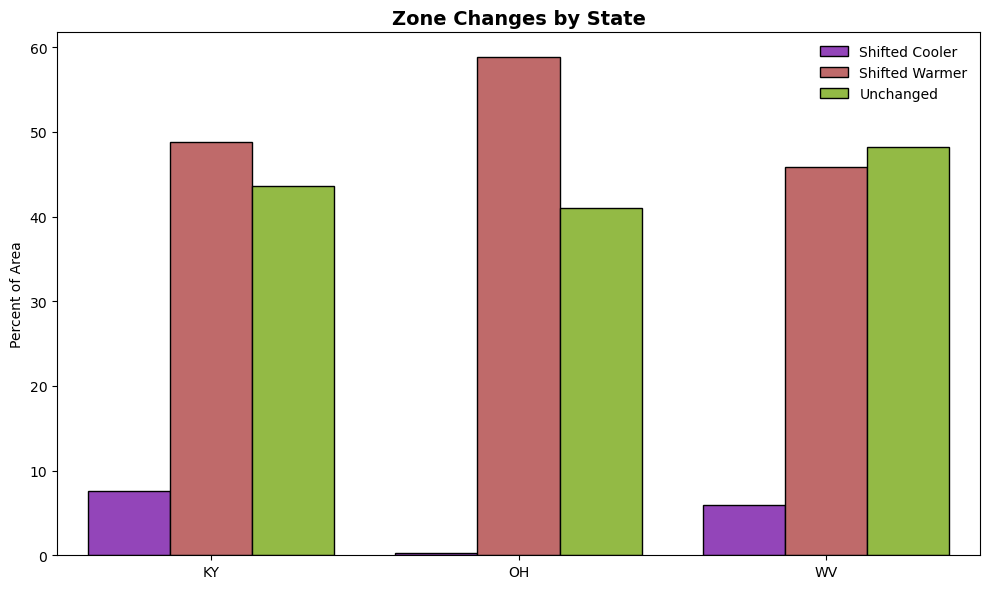

In [160]:
plt.figure(figsize=(10,6))

palette = {
    'Shifted Warmer': 'indianred', 
    'Unchanged': 'yellowgreen',       
    'Shifted Cooler': 'darkorchid'  
}

sns.barplot(
    data=zones_summary,
    x='State',
    y='Percent',
    hue='ChangeType',
    palette=palette,
    edgecolor='black'
)

plt.title('Zone Changes by State', fontsize=14, weight='bold')
plt.xlabel('')
plt.ylabel('Percent of Area')
plt.xticks(rotation=0)
plt.legend(title='', frameon=False)
plt.tight_layout()
plt.show()

In [166]:
baseline = tristate_weather[(tristate_weather['Year'] >= 1990) & (tristate_weather['Year'] <= 1999)]['Ext Max Temp'].mean()
recent = tristate_weather[(tristate_weather['Year'] >= 2010) & (tristate_weather['Year'] <= 2024)]['Ext Max Temp'].mean()

warming_percent = ((recent - baseline) / baseline) * 100
print(f"Extreme maximum temperature warming percentage: {warming_percent:.2f}%")

Extreme maximum temperature warming percentage: 1.00%


In [172]:
baseline_ext = tristate_weather[(tristate_weather['Year'] >= 1990) & (tristate_weather['Year'] <= 1999)]['Ext Min Temp'].mean()
recent_ext = tristate_weather[(tristate_weather['Year'] >= 2010) & (tristate_weather['Year'] <= 2024)]['Ext Min Temp'].mean()

warming_percent_ext = ((recent_ext - baseline_ext) / (baseline_ext)) * 100
print(f"Extreme minimum temperature warming percentage: {warming_percent_ext:.2f}%")

Extreme minimum temperature warming percentage: 5.04%


In [168]:
baseline_avg = tristate_weather[(tristate_weather['Year'] >= 1990) & (tristate_weather['Year'] <= 1999)]['Avg Temp'].mean()
recent_avg = tristate_weather[(tristate_weather['Year'] >= 2010) & (tristate_weather['Year'] <= 2024)]['Avg Temp'].mean()

warming_percent_avg = ((recent_avg - baseline_avg) / baseline_avg) * 100
print(f"Average temperature warming percentage: {warming_percent_avg:.2f}%")

Average temperature warming percentage: 2.25%
